In [1204]:
library(tidyverse)
library(stargazer)
library(olsrr)
library(readr)
library(readxl)
library(writexl)
library(dplyr)
library(broom)
library(car)
library(lmtest)
library(corpcor)
library(sandwich)
library(fastDummies)
library(plm)
library(forecast)
library(repr)
library(forcats)

In [1205]:
options(repr.plot.width=15, repr.plot.height=10)
options(scipen=99)

theme = theme_linedraw() + theme(
  title = element_text(size = 18),
  axis.text.x = element_text(size = 16),
  axis.title.x = element_text(size = 18),
  axis.text.y = element_text(size = 16),
  axis.title.y = element_text(size = 18),
  legend.text = element_text(size= 12)
) 

# Setup Forecasts

## 2022 VMT Forecast

In [1206]:
vmt.ann = read_excel('data/WorkingData.xlsx', sheet = 'IN-VMT-clean')[1:30,]
colnames(vmt.ann) = c('year','vmt')

vmt.2022.m = lm(vmt ~ year, vmt.ann)


vmt.ann[nrow(vmt.ann)+1,] = 2022
vmt.ann$vmt[length(vmt.ann$vmt)] = vmt.2022.m$coefficients[[1]] + vmt.2022.m$coefficients[[2]]*2022
vmt.ann$vmt = vmt.ann$vmt*1000000

New names:
* `` -> `...1`


## IN TPI Forecast

In [1207]:
tpi = read_excel('data/WorkingData.xlsx',sheet='TPI')[2:5]
tpi$tpi = tpi$`tpi (millions)`
tpi$year = factor(tpi$year)
tpi$quarter = factor(tpi$quarter)
tpi = dummy_cols(tpi, select_columns = c('year','quarter'))

tpi.ann = aggregate(tpi~year,tpi,mean)

In [1208]:
names(tpi)

[1] "year"           "quarter"        "time"           "tpi (millions)"
 [5] "tpi"            "year_1948"      "year_1949"      "year_1950"     
 [9] "year_1951"      "year_1952"      "year_1953"      "year_1954"     
[13] "year_1955"      "year_1956"      "year_1957"      "year_1958"     
[17] "year_1959"      "year_1960"      "year_1961"      "year_1962"     
[21] "year_1963"      "year_1964"      "year_1965"      "year_1966"     
[25] "year_1967"      "year_1968"      "year_1969"      "year_1970"     
[29] "year_1971"      "year_1972"      "year_1973"      "year_1974"     
[33] "year_1975"      "year_1976"      "year_1977"      "year_1978"     
[37] "year_1979"      "year_1980"      "year_1981"      "year_1982"     
[41] "year_1983"      "year_1984"      "year_1985"      "year_1986"     
[45] "year_1987"      "year_1988"      "year_1989"      "year_1990"     
[49] "year_1991"      "year_1992"      "year_1993"      "year_1994"     
[53] "year_1995"      "year_1996"      "year_1997"      "year_1998"     
[57] "year_1999"      "year_2000"      "year_2001"      "year_2002"     
[61] "year_2003"      "year_2004"      "year_2005"      "year_2006"     
[65] "year_2007"      "year_2008"      "year_2009"      "year_2010"     
[69] "year_2011"      "year_2012"      "year_2013"      "year_2014"     
[73] "year_2015"      "year_2016"      "year_2017"      "year_2018"     
[77] "year_2019"      "year_2020"      "year_2021"      "year_2022"     
[81] "quarter_0"      "quarter_1"      "quarter_2"      "quarter_3"

In [1209]:
tpi.m = lm(tpi ~ time + quarter + year, tpi)
data.frame(tpi.m$coefficients)

,tpi.m.coefficients
,<dbl>
(Intercept),-10268403679261
time,5273283108
quarter1,764246408
quarter2,1155112815
quarter3,2099637890
year1949,-5516833108
year1950,-10112941216
year1951,-14392824324
year1952,-19299807432


In [1210]:
# create dataframe
tpi.fc = data.frame(year = c(rep(2023:2042,4)))
tpi.fc = data.frame(year = c(tpi.fc[order(tpi.fc$year),]))
tpi.fc$qtr = c(0:3)
tpi.fc$time = tpi.fc$year+(tpi.fc$qtr/4)
tpi.fc = dummy_cols(tpi.fc, 'qtr')
tpi.fc

year,qtr,time,qtr_0,qtr_1,qtr_2,qtr_3
<int>,<int>,<dbl>,<int>,<int>,<int>,<int>
2023,0,2023.00,1,0,0,0
2023,1,2023.25,0,1,0,0
2023,2,2023.50,0,0,1,0
2023,3,2023.75,0,0,0,1
2024,0,2024.00,1,0,0,0
2024,1,2024.25,0,1,0,0
2024,2,2024.50,0,0,1,0
2024,3,2024.75,0,0,0,1
2025,0,2025.00,1,0,0,0


In [1211]:
tpi.fc$tpi = tpi.m$coefficients[[1]] + tpi.m$coefficients[[2]]*tpi.fc$time + tpi.m$coefficients[[3]]*tpi.fc$qtr_1 + tpi.m$coefficients[[4]]*tpi.fc$qtr_2 + 
    tpi.m$coefficients[[5]]*tpi.fc$qtr_3 + tpi.m$coefficients[[78]]
tpi.fc.ann = aggregate(tpi ~ year, tpi.fc, mean)

# Income Correlations

## Income and VMT

In [1212]:
nhts = read.csv('data/vehpub.csv')
nhts2 = nhts[c('HHSTATE','HHFAMINC','BESTMILE','GSYRGAL')]
nhts.in = nhts2[nhts2$HHSTATE=='IN',]
nhts.in = nhts.in[nhts.in$BESTMILE != -9,]
nhts.in = nhts.in[nhts.in$BESTMILE != max(nhts.in$BESTMILE),]
nhts.in = nhts.in[nhts.in$BESTMILE != max(nhts.in$BESTMILE),]

In [1213]:
incmile.mean = aggregate(BESTMILE ~ HHFAMINC,data=nhts.in,mean)
incmile.sum = aggregate(BESTMILE ~ HHFAMINC,data=nhts.in,sum)
incmile.mean$Bracket = c('a','b','c','Less than $10,000','$10,000-$14,999','$15,000-$24,999',
    '$25,000-$34,999','$35,000-$49,999','$50,000-$74,999','$75,000-$99,999','$100,000-$124,999','$125,000-$149,999',
    '$150,000-$199,999','$200,000 or more')
incmile.sum$Bracket = c('a','b','c','Less than $10,000','$10,000-$14,999','$15,000-$24,999',
    '$25,000-$34,999','$35,000-$49,999','$50,000-$74,999','$75,000-$99,999','$100,000-$124,999','$125,000-$149,999',
    '$150,000-$199,999','$200,000 or more')
incmile.mean = incmile.mean[c('HHFAMINC','Bracket','BESTMILE')][4:14,]
incmile.sum = incmile.sum[c('HHFAMINC','Bracket','BESTMILE')][4:14,]


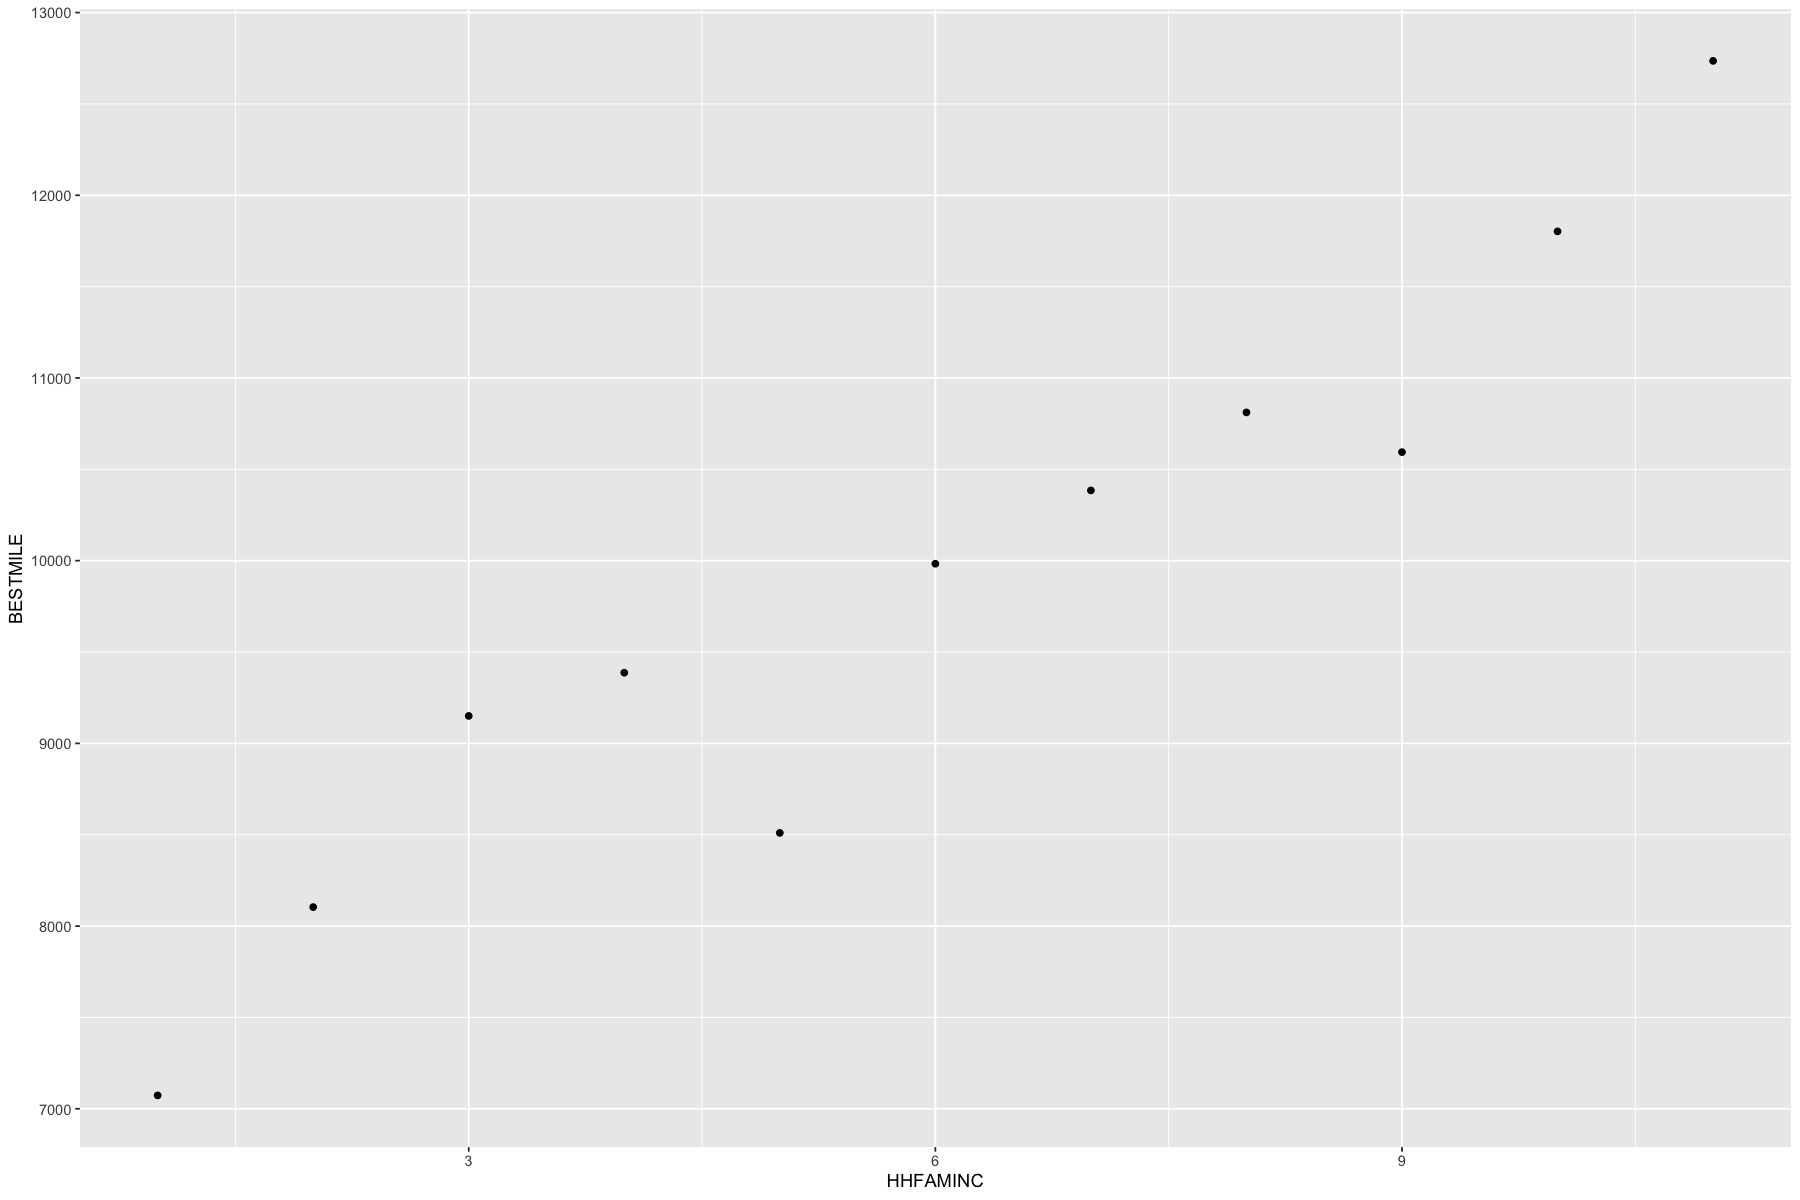

In [1214]:
incmile.gg = incmile.mean[c('HHFAMINC','Bracket','BESTMILE')][4:14,]
ggplot(incmile.mean, aes(HHFAMINC,BESTMILE)) + geom_point()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


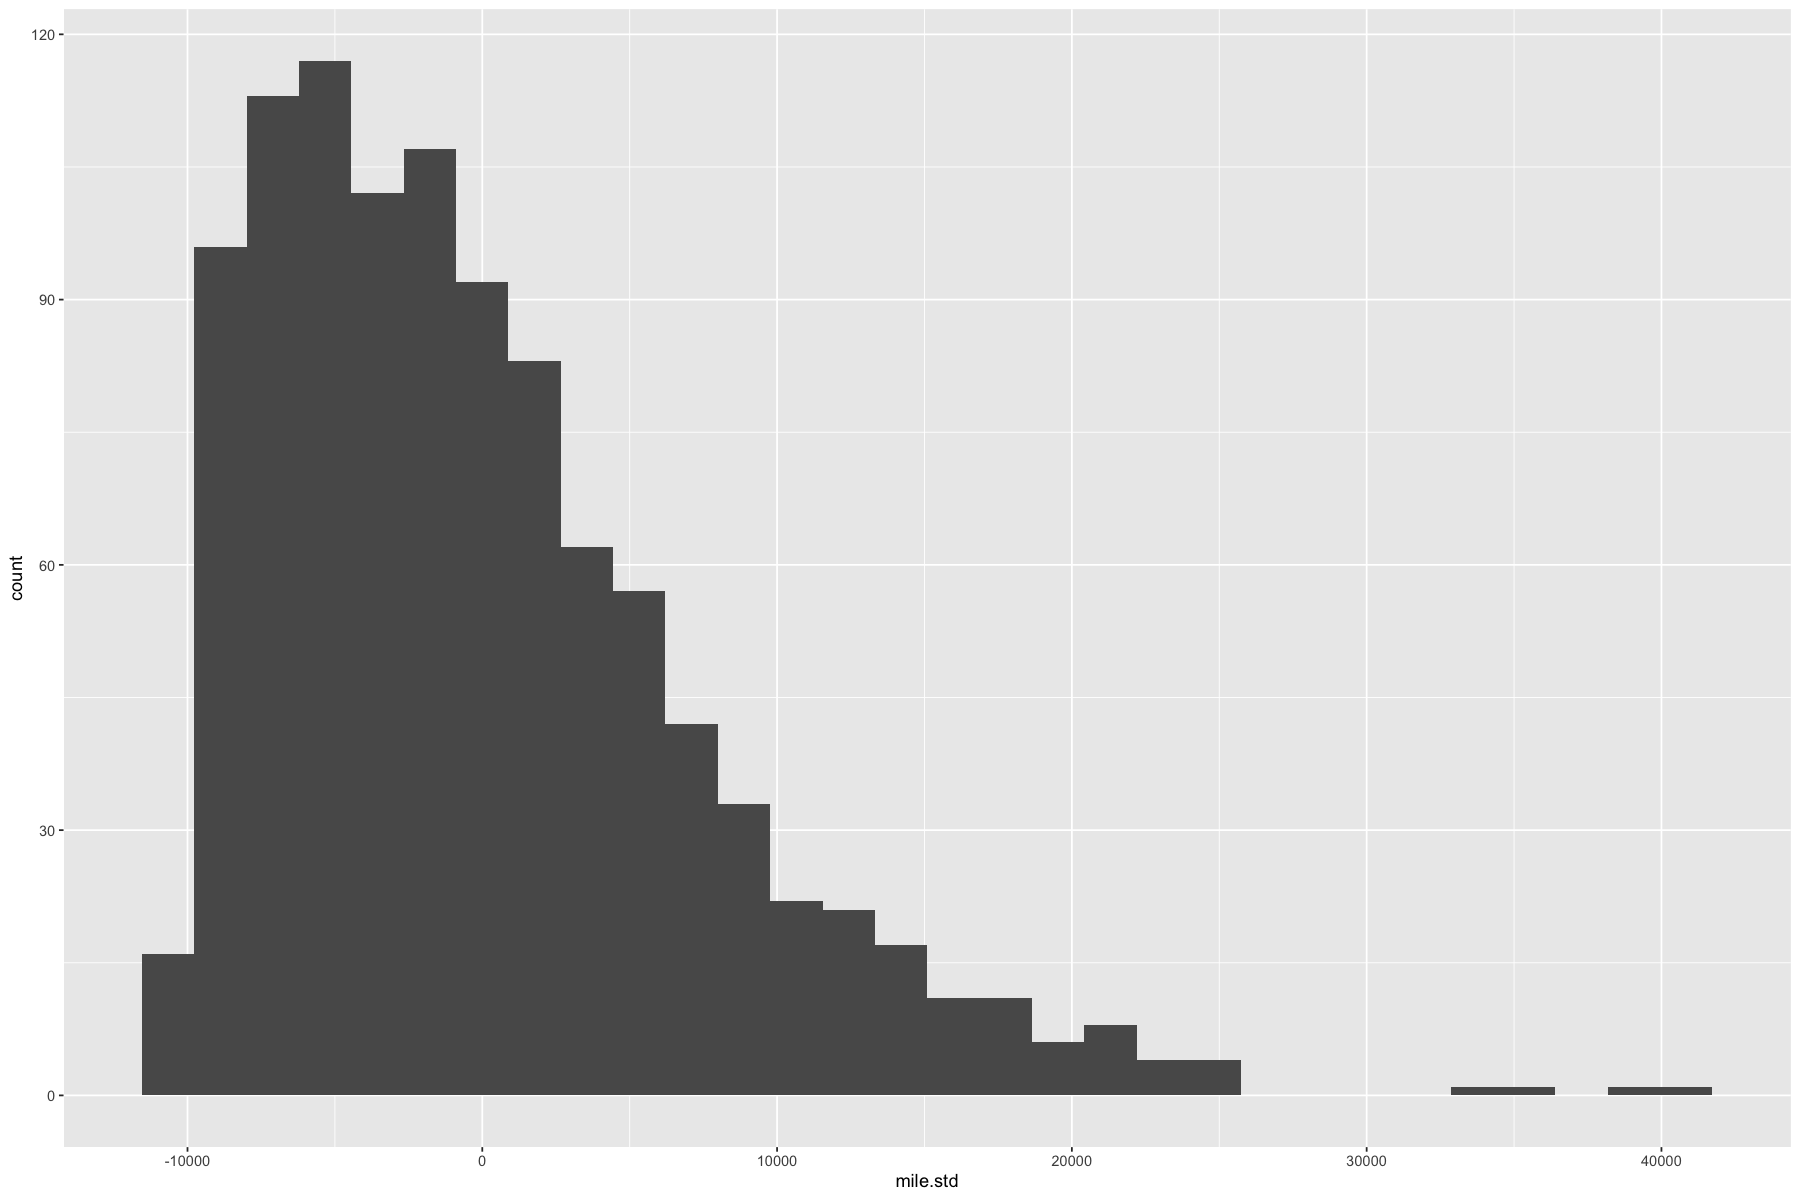

In [1215]:
nhts.in$mile.std = nhts.in$BESTMILE-mean(nhts.in$BESTMILE)

ggplot(nhts.in, aes(mile.std))+ geom_histogram()

In [1216]:
nhts.in$HHFAMINC = as.factor(nhts.in$HHFAMINC)
summary(lm(BESTMILE ~  HHFAMINC, nhts.in))


Call:
lm(formula = BESTMILE ~ HHFAMINC, data = nhts.in)

Residuals:
   Min     1Q Median     3Q    Max 
-12647  -5566  -1553   3981  42342 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)    15000       7531   1.992   0.0467 *
HHFAMINC-8     -6307       7988  -0.790   0.4299  
HHFAMINC-7     -6984       7708  -0.906   0.3651  
HHFAMINC1      -7927       7693  -1.030   0.3031  
HHFAMINC2      -6896       7659  -0.900   0.3681  
HHFAMINC3      -5850       7588  -0.771   0.4409  
HHFAMINC4      -5613       7570  -0.742   0.4586  
HHFAMINC5      -6490       7555  -0.859   0.3905  
HHFAMINC6      -5017       7547  -0.665   0.5064  
HHFAMINC7      -4615       7557  -0.611   0.5415  
HHFAMINC8      -4188       7562  -0.554   0.5797  
HHFAMINC9      -4406       7589  -0.581   0.5617  
HHFAMINC10     -3198       7629  -0.419   0.6752  
HHFAMINC11     -2264       7664  -0.295   0.7677  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual st

## Income and MPG

In [1217]:
nhts$mpg = nhts$BESTMILE/nhts$GSYRGAL
incmpg = aggregate(mpg ~ HHFAMINC,nhts,mean)[4:14,]
incmpg$Bracket = c('Less than $10,000','$10,000-$14,999','$15,000-$24,999',
    '$25,000-$34,999','$35,000-$49,999','$50,000-$74,999','$75,000-$99,999','$100,000-$124,999','$125,000-$149,999',
    '$150,000-$199,999','$200,000 or more')

# Gas Tax Analysis

## Gas Forecast

### Setup

In [1218]:
gas = read_excel('data/WorkingData.xlsx', sheet = 'GasRevMonthly')
gas = dummy_cols(gas, select_columns = c('mnth','year'))
gas$time = gas$year+gas$mnth/12
gas$year = factor(gas$year)
gas$mnth = factor(gas$mnth)


In [1219]:
share.ann = read_excel('data/WorkingData.xlsx', sheet = 'share.ann')
share.m = lm(share ~ I(year^2) + year, share.ann)
reg.m = lm(registered ~ I(year^2) + year, share.ann)
ev.m = lm(ev ~ I(year^2) + year, share.ann)

In [1220]:
share.mnth = read_excel('data/WorkingData.xlsx', sheet = 'share.mnth')
share.mnth$share.hat = share.m$coefficients[[1]] + share.m$coefficients[[2]]*(share.mnth$time^2) + 
    share.m$coefficients[[3]]*share.mnth$time
share.mnth$reg.hat = reg.m$coefficients[[1]] + reg.m$coefficients[[2]]*(share.mnth$time^2) + 
    reg.m$coefficients[[3]]*share.mnth$time
share.mnth$ev.hat = ev.m$coefficients[[1]] + ev.m$coefficients[[2]]*(share.mnth$time^2) + 
    ev.m$coefficients[[3]]*share.mnth$time
# write_xlsx(share.mnth,'data/sharemnth.xlsx')

### Forecast

In [1221]:
names(gas)

[1] "year"           "month"          "mnth"           "key"           
 [5] "avg.vmt.share"  "gas.rev.ann"    "gas.base.ann"   "gas.tax"       
 [9] "gas.base.mnth"  "gas.rev.mnth"   "vmt.ann (mill)" "vmt.mnth"      
[13] "avg.mpg"        "ev.count"       "mnth_0"         "mnth_1"        
[17] "mnth_2"         "mnth_3"         "mnth_4"         "mnth_5"        
[21] "mnth_6"         "mnth_7"         "mnth_8"         "mnth_9"        
[25] "mnth_10"        "mnth_11"        "year_1999"      "year_2000"     
[29] "year_2001"      "year_2002"      "year_2003"      "year_2004"     
[33] "year_2005"      "year_2006"      "year_2007"      "year_2008"     
[37] "year_2009"      "year_2010"      "year_2011"      "year_2012"     
[41] "year_2013"      "year_2014"      "year_2015"      "year_2016"     
[45] "year_2017"      "year_2018"      "year_2019"      "year_2020"     
[49] "year_2021"      "year_2022"      "time"

#### Revenue

In [1222]:
gas.m = lm(gas.rev.mnth ~ time + mnth + year, gas)
summary(gas.m)


Call:
lm(formula = gas.rev.mnth ~ time + mnth + year, data = gas)

Residuals:
     Min       1Q   Median       3Q      Max 
-9263212  -493118   -64545   506825  3723924 

Coefficients: (1 not defined because of singularities)
               Estimate  Std. Error t value             Pr(>|t|)    
(Intercept) -3843135483    48453750 -79.316 < 0.0000000000000002 ***
time            1938964       24100  80.456 < 0.0000000000000002 ***
mnth1          -2552733      391948  -6.513   0.0000000003946020 ***
mnth2           4165302      391963  10.627 < 0.0000000000000002 ***
mnth3           3217038      391989   8.207   0.0000000000000116 ***
mnth4           5866775      392025  14.965 < 0.0000000000000002 ***
mnth5           6040829      392071  15.407 < 0.0000000000000002 ***
mnth6           7197290      392128  18.354 < 0.0000000000000002 ***
mnth7           6683633      392195  17.042 < 0.0000000000000002 ***
mnth8           2494426      392272   6.359   0.0000000009431280 ***
mnth9         

In [1223]:
# create dataframe
gas.fc = data.frame(year = c(rep(2023:2042,12)))
gas.fc = data.frame(year = c(gas.fc[order(gas.fc$year),]))
gas.fc$mnth = c(0:11)
gas.fc$time = gas.fc$year+(gas.fc$mnth/12)
gas.fc$vmt = NA
gas.fc$rate = NA
gas.fc$rev = NA
gas.fc = dummy_cols(gas.fc, select_columns = c('mnth'))

In [1224]:
gas.fc$gas.rev = gas.m$coefficients[[1]] + gas.m$coefficients[[2]]*gas.fc$time + gas.m$coefficients[[3]]*gas.fc$mnth_1 +
    gas.m$coefficients[[4]]*gas.fc$mnth_2 + gas.m$coefficients[[5]]*gas.fc$mnth_3 + gas.m$coefficients[[6]]*gas.fc$mnth_4 + 
    gas.m$coefficients[[7]]*gas.fc$mnth_5 + gas.m$coefficients[[8]]*gas.fc$mnth_6 + gas.m$coefficients[[9]]*gas.fc$mnth_7 + 
    gas.m$coefficients[[10]]*gas.fc$mnth_8 + gas.m$coefficients[[11]]*gas.fc$mnth_9 + gas.m$coefficients[[12]]*gas.fc$mnth_10 + 
    gas.m$coefficients[[13]]*gas.fc$mnth_11 + gas.m$coefficients[[35]]

In [1225]:
gas$rev.hat = gas.m$coefficients[[1]] + gas.m$coefficients[[2]]*gas$time + gas.m$coefficients[[3]]*gas$mnth_1 +
    gas.m$coefficients[[4]]*gas$mnth_2 + gas.m$coefficients[[5]]*gas$mnth_3 + gas.m$coefficients[[6]]*gas$mnth_4 + 
    gas.m$coefficients[[7]]*gas$mnth_5 + gas.m$coefficients[[8]]*gas$mnth_6 + gas.m$coefficients[[9]]*gas$mnth_7 + 
    gas.m$coefficients[[10]]*gas$mnth_8 + gas.m$coefficients[[11]]*gas$mnth_9 + gas.m$coefficients[[12]]*gas$mnth_10 + 
    gas.m$coefficients[[13]]*gas$mnth_11 + gas.m$coefficients[[14]]*gas$year_2000 + gas.m$coefficients[[15]]*gas$year_2001 +
    gas.m$coefficients[[16]]*gas$year_2002 + gas.m$coefficients[[17]]*gas$year_2003 + gas.m$coefficients[[18]]*gas$year_2004 +
    gas.m$coefficients[[19]]*gas$year_2005 + gas.m$coefficients[[20]]*gas$year_2006 + gas.m$coefficients[[21]]*gas$year_2007 + 
    gas.m$coefficients[[22]]*gas$year_2008 + gas.m$coefficients[[23]]*gas$year_2009 + gas.m$coefficients[[24]]*gas$year_2010 + 
    gas.m$coefficients[[25]]*gas$year_2011 + gas.m$coefficients[[26]]*gas$year_2012 + gas.m$coefficients[[27]]*gas$year_2013 + 
    gas.m$coefficients[[28]]*gas$year_2014 + gas.m$coefficients[[29]]*gas$year_2015 + gas.m$coefficients[[30]]*gas$year_2016 + 
    gas.m$coefficients[[31]]*gas$year_2017 + gas.m$coefficients[[32]]*gas$year_2018 + gas.m$coefficients[[33]]*gas$year_2019 + 
    gas.m$coefficients[[34]]*gas$year_2020 + gas.m$coefficients[[35]]*gas$year_2021 + gas.m$coefficients[[35]]*gas$year_2022

In [1226]:
gas.fc.ann = aggregate(gas.rev~year,gas.fc,sum)

#### Scoring

##### Constant Rate

In [1227]:
base.m = lm(gas.base.mnth ~ time + mnth + year, gas)

base.fc = data.frame(year = c(rep(2023:2042,12)))
base.fc = data.frame(year = c(base.fc[order(base.fc$year),]))
base.fc$mnth = c(0:11)
base.fc$time = base.fc$year+(base.fc$mnth/12)
base.fc$rate = NA
base.fc$rev = NA
base.fc = dummy_cols(base.fc, select_columns = 'mnth')

In [1228]:
base.fc$gas.base = base.m$coefficients[[1]] + base.m$coefficients[[2]]*base.fc$time + base.m$coefficients[[3]]*base.fc$mnth_1 +
    base.m$coefficients[[4]]*base.fc$mnth_2 + base.m$coefficients[[5]]*base.fc$mnth_3 + base.m$coefficients[[6]]*base.fc$mnth_4 + 
    base.m$coefficients[[7]]*base.fc$mnth_5 + base.m$coefficients[[8]]*base.fc$mnth_6 + base.m$coefficients[[9]]*base.fc$mnth_7 + 
    base.m$coefficients[[10]]*base.fc$mnth_8 + base.m$coefficients[[11]]*base.fc$mnth_9 + base.m$coefficients[[12]]*base.fc$mnth_10 + 
    base.m$coefficients[[13]]*base.fc$mnth_11 + base.m$coefficients[[35]]

In [1229]:
constg.fc = aggregate(gas.base ~ year, base.fc, sum)
constg.fc$rate = 0.33
constg.fc$rev = constg.fc$rate*constg.fc$gas.base
constg.fc

year,gas.base,rate,rev
<int>,<dbl>,<dbl>,<dbl>
2023,2865032795,0.33,945460822
2024,2864959096,0.33,945436502
2025,2864885397,0.33,945412181
2026,2864811698,0.33,945387860
2027,2864737999,0.33,945363540
2028,2864664299,0.33,945339219
2029,2864590600,0.33,945314898
2030,2864516901,0.33,945290577
2031,2864443202,0.33,945266257


#### Scoring (+$0.01 per year)

#### Static

In [1230]:
staticg.fc = base.fc
staticg.fc$rate = 0.33
for (r in 2:length(staticg.fc$gas.base))
    staticg.fc$rate[r] = staticg.fc$rate[r-1]+0.01
staticg.fc$rev.static = staticg.fc$rate*staticg.fc$gas.base
staticg.fc

year,mnth,time,rate,rev,mnth_0,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,gas.base,rev.static
<int>,<int>,<dbl>,<dbl>,<lgl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
2023,0,2023.000,0.33,NA,1,0,0,0,0,0,0,0,0,0,0,0,216200182,71346060
2023,1,2023.083,0.34,NA,0,1,0,0,0,0,0,0,0,0,0,0,205031693,69710775
2023,2,2023.167,0.35,NA,0,0,1,0,0,0,0,0,0,0,0,0,239869957,83954485
2023,3,2023.250,0.36,NA,0,0,0,1,0,0,0,0,0,0,0,0,237363342,85450803
2023,4,2023.333,0.37,NA,0,0,0,0,1,0,0,0,0,0,0,0,250255804,92594647
2023,5,2023.417,0.38,NA,0,0,0,0,0,1,0,0,0,0,0,0,251206392,95458429
2023,6,2023.500,0.39,NA,0,0,0,0,0,0,1,0,0,0,0,0,257540038,100440615
2023,7,2023.583,0.40,NA,0,0,0,0,0,0,0,1,0,0,0,0,256287245,102514898
2023,8,2023.667,0.41,NA,0,0,0,0,0,0,0,0,1,0,0,0,235312863,96478274


##### Microdynamic

In [1231]:
microg.fc = base.fc
microg.fc$rate = 0.33
microg.fc$elas = -0.03
for (r in 2:length(microg.fc$gas.base))
    if (microg.fc$year[r] == microg.fc$year[r-1]) {
        microg.fc$rate[r] = microg.fc$rate[r-1]
    } else {
        microg.fc$rate[r] = microg.fc$rate[r-1]+0.01
    }
microg.fc$taxperchange = (0.34-0.33)/0.33
for (r in 2:length(microg.fc$gas.base))
    microg.fc$taxperchange[r] = (microg.fc$rate[r]-microg.fc$rate[r-1])/microg.fc$rate[r-1]
microg.fc$baseperchange = microg.fc$elas*microg.fc$taxperchange
microg.fc$basechange = microg.fc$baseperchange*microg.fc$gas.base
microg.fc$base.micro = microg.fc$gas.base+microg.fc$basechange
microg.fc$rev.micro = microg.fc$base.micro*microg.fc$rate
microg.fc

year,mnth,time,rate,rev,mnth_0,mnth_1,mnth_2,mnth_3,mnth_4,...,mnth_9,mnth_10,mnth_11,gas.base,elas,taxperchange,baseperchange,basechange,base.micro,rev.micro
<int>,<int>,<dbl>,<dbl>,<lgl>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2023,0,2023.000,0.33,NA,1,0,0,0,0,...,0,0,0,216200182,-0.03,0.03030303,-0.0009090909,-196545.6,216003636,71281200
2023,1,2023.083,0.33,NA,0,1,0,0,0,...,0,0,0,205031693,-0.03,0.00000000,0.0000000000,0.0,205031693,67660459
2023,2,2023.167,0.33,NA,0,0,1,0,0,...,0,0,0,239869957,-0.03,0.00000000,0.0000000000,0.0,239869957,79157086
2023,3,2023.250,0.33,NA,0,0,0,1,0,...,0,0,0,237363342,-0.03,0.00000000,0.0000000000,0.0,237363342,78329903
2023,4,2023.333,0.33,NA,0,0,0,0,1,...,0,0,0,250255804,-0.03,0.00000000,0.0000000000,0.0,250255804,82584415
2023,5,2023.417,0.33,NA,0,0,0,0,0,...,0,0,0,251206392,-0.03,0.00000000,0.0000000000,0.0,251206392,82898109
2023,6,2023.500,0.33,NA,0,0,0,0,0,...,0,0,0,257540038,-0.03,0.00000000,0.0000000000,0.0,257540038,84988213
2023,7,2023.583,0.33,NA,0,0,0,0,0,...,0,0,0,256287245,-0.03,0.00000000,0.0000000000,0.0,256287245,84574791
2023,8,2023.667,0.33,NA,0,0,0,0,0,...,0,0,0,235312863,-0.03,0.00000000,0.0000000000,0.0,235312863,77653245


##### Comparison

In [1232]:
microg.fc.ann = aggregate(rev.micro ~ year, microg.fc, sum)
staticg.fc.ann = aggregate(rev.static ~ year, staticg.fc, sum)

In [1233]:
scoreg.fc = data.frame(year = c(rep(2023:2042,12)))
scoreg.fc = data.frame(year = c(scoreg.fc[order(scoreg.fc$year),]))
scoreg.fc$base.static = 1
scoreg.fc = aggregate(base.static ~ year, scoreg.fc,sum)
scoreg.fc$base.static = staticg.fc.ann$gas.base
scoreg.fc$rev.static = staticg.fc.ann$rev.static
scoreg.fc$base.micro = microg.fc.ann$base.micro
scoreg.fc$rev.micro = microg.fc.ann$rev.micro
scoreg.fc$difference = scoreg.fc$rev.static-scoreg.fc$rev.micro
scoreg.fc

year,rev.static,rev.micro,difference
<int>,<dbl>,<dbl>,<dbl>
2023,1105678707,945395962,160282745
2024,1449445425,974019269,475426155
2025,1793194454,1002643125,790551329
2026,2136925796,1031265504,1105660292
2027,2480639450,1059886405,1420753044
2028,2824335416,1088505830,1735829586
2029,3168013694,1117123779,2050889916
2030,3511674285,1145740251,2365934034
2031,3855317188,1174355246,2680961941


## Relationship Analysis

In [1234]:
names(gas)

[1] "year"           "month"          "mnth"           "key"           
 [5] "avg.vmt.share"  "gas.rev.ann"    "gas.base.ann"   "gas.tax"       
 [9] "gas.base.mnth"  "gas.rev.mnth"   "vmt.ann (mill)" "vmt.mnth"      
[13] "avg.mpg"        "ev.count"       "mnth_0"         "mnth_1"        
[17] "mnth_2"         "mnth_3"         "mnth_4"         "mnth_5"        
[21] "mnth_6"         "mnth_7"         "mnth_8"         "mnth_9"        
[25] "mnth_10"        "mnth_11"        "year_1999"      "year_2000"     
[29] "year_2001"      "year_2002"      "year_2003"      "year_2004"     
[33] "year_2005"      "year_2006"      "year_2007"      "year_2008"     
[37] "year_2009"      "year_2010"      "year_2011"      "year_2012"     
[41] "year_2013"      "year_2014"      "year_2015"      "year_2016"     
[45] "year_2017"      "year_2018"      "year_2019"      "year_2020"     
[49] "year_2021"      "year_2022"      "time"           "rev.hat"

In [1235]:
rel.m = lm(gas.rev.mnth ~  gas.base.mnth + gas.tax + log(ev.count+1) + mnth + time + year, gas)
summary(rel.m)


Call:
lm(formula = gas.rev.mnth ~ gas.base.mnth + gas.tax + log(ev.count + 
    1) + mnth + time + year, data = gas)

Residuals:
     Min       1Q   Median       3Q      Max 
-3866706  -282574    -1106   279441  2689350 

Coefficients: (3 not defined because of singularities)
                          Estimate       Std. Error t value
(Intercept)       -124356741.88383 5101832953.84907  -0.024
gas.base.mnth              0.22398          0.01357  16.506
gas.tax            369595613.08714  193729193.99301   1.908
log(ev.count + 1)   -2391565.14180    2768606.09909  -0.864
mnth1                 108200.60404     374459.14287   0.289
mnth2                -817310.63328     609248.88714  -1.342
mnth3               -1044706.50362     763489.20774  -1.368
mnth4               -1123148.51379    1025188.17948  -1.096
mnth5               -1002562.16478    1218079.95212  -0.823
mnth6               -1105252.48219    1446642.37106  -0.764
mnth7               -1178869.37839    1635881.41200  -0.721
mn

## Adequacy Assessment 

### Historical Data (2022 USD)

In [1236]:
adeq <- read_excel('data/WorkingData.xlsx', sheet = "GasRev")

#### Buoyancy

In [1237]:
buoy.gas <- lm(log(gas.rev.real) ~ log(tpi.real), adeq)
summary(buoy.gas)

# Buoyancy = 0.4631


Call:
lm(formula = log(gas.rev.real) ~ log(tpi.real), data = adeq)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.21902 -0.12223  0.04285  0.11055  0.19839 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)  
(Intercept)     8.2313     6.7323   1.223   0.2344  
log(tpi.real)   0.4631     0.2536   1.826   0.0815 .
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1406 on 22 degrees of freedom
Multiple R-squared:  0.1316,	Adjusted R-squared:  0.09212 
F-statistic: 3.334 on 1 and 22 DF,  p-value: 0.08148


#### Elasticity

In [1238]:
elas.gas <- lm(log(base) ~ log(tpi.real) + c1 + c2 + c2 + c3 + c4 + c5 + c6,adeq)
summary(elas.gas)

# Elasticity = -0.07843


Call:
lm(formula = log(base) ~ log(tpi.real) + c1 + c2 + c2 + c3 + 
    c4 + c5 + c6, data = adeq)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.06513 -0.01927  0.00000  0.02351  0.05355 

Coefficients:
              Estimate Std. Error t value  Pr(>|t|)    
(Intercept)   23.93921    3.95273   6.056 0.0000167 ***
log(tpi.real) -0.07843    0.14964  -0.524     0.607    
c1            -0.02068    0.02635  -0.785     0.444    
c2            -0.02621    0.04499  -0.583     0.568    
c3             0.02925    0.05436   0.538     0.598    
c4            -0.06706    0.05497  -1.220     0.240    
c5             0.02185    0.05449   0.401     0.694    
c6             0.03368    0.05470   0.616     0.547    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.03835 on 16 degrees of freedom
Multiple R-squared:  0.4053,	Adjusted R-squared:  0.1451 
F-statistic: 1.558 on 7 and 16 DF,  p-value: 0.2184


#### Stability

In [1239]:
stabg <- data.frame(SD = c(sd(adeq$d.gas.real),sd(adeq$d.tpi.real),sd(adeq$d.base)),
                   Max = c(max(adeq$d.gas.real),max(adeq$d.tpi.real),max(adeq$d.base)),
                   Min = c(min(adeq$d.gas.real),min(adeq$d.tpi.real),min(adeq$d.base)),
                   row.names = c('Change in Revenue','Change in Economic Activity',
                                 'Change in Base'))
stabg*100

,SD,Max,Min
,<dbl>,<dbl>,<dbl>
Change in Revenue,10.744618,48.708014,-6.595596
Change in Economic Activity,2.205255,6.187193,-4.684276
Change in Base,4.500163,12.408989,-10.169525


### Forecasted Data

#### Setup

In [1240]:
adeq.fc = read_excel('data/WorkingData.xlsx',sheet = 'adeq')

#### Buoyancy

In [1241]:
buoy.gas.fc <- lm(log(gas.rev) ~ log(tpi), adeq.fc)
summary(buoy.gas.fc)

# Buoyancy = 2.01027


Call:
lm(formula = log(gas.rev) ~ log(tpi), data = adeq.fc)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.009002 -0.003103  0.001173  0.003745  0.004768 

Coefficients:
             Estimate Std. Error t value            Pr(>|t|)    
(Intercept) -33.01030    0.39449  -83.68 <0.0000000000000002 ***
log(tpi)      2.01027    0.01471  136.68 <0.0000000000000002 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.004494 on 18 degrees of freedom
Multiple R-squared:  0.999,	Adjusted R-squared:  0.999 
F-statistic: 1.868e+04 on 1 and 18 DF,  p-value: < 0.00000000000000022


#### Elasticity

In [1242]:
elas.gas.fc <- lm(log(base) ~ log(tpi) + c0 + c1 + c2 + c3 + c4 + c5 + c6 + c7 + c8 + c9 + c10 + c11 + c12 + c13 + c14 + c15 + c16 + c17 + c18 + c19, adeq.fc)
summary(elas.gas.fc)

# elas = -0.001308


Call:
lm(formula = log(base) ~ log(tpi) + c0 + c1 + c2 + c3 + c4 + 
    c5 + c6 + c7 + c8 + c9 + c10 + c11 + c12 + c13 + c14 + c15 + 
    c16 + c17 + c18 + c19, data = adeq.fc)

Residuals:
ALL 20 residuals are 0: no residual degrees of freedom!

Coefficients: (2 not defined because of singularities)
                Estimate Std. Error t value Pr(>|t|)
(Intercept) 21.809867017        NaN     NaN      NaN
log(tpi)    -0.001307996        NaN     NaN      NaN
c0                    NA         NA      NA       NA
c1          -0.000008438        NaN     NaN      NaN
c2           0.000018098        NaN     NaN      NaN
c3           0.000016348        NaN     NaN      NaN
c4           0.000014731        NaN     NaN      NaN
c5           0.000013233        NaN     NaN      NaN
c6           0.000011842        NaN     NaN      NaN
c7           0.000010547        NaN     NaN      NaN
c8           0.000009339        NaN     NaN      NaN
c9           0.000008210        NaN     NaN      NaN
c10      

#### Stability

In [1243]:
stabg.fc <- data.frame(SD = c(sd(adeq.fc$d.rev),sd(adeq.fc$d.tpi),sd(adeq.fc$d.base)),
                   Max = c(max(adeq.fc$d.rev),max(adeq.fc$d.tpi),max(adeq.fc$d.base)),
                   Min = c(min(adeq.fc$d.rev),min(adeq.fc$d.tpi),min(adeq.fc$d.base)),
                   row.names = c('Change in Revenue','Change in Economic Activity',
                                 'Change in Base'))
stabg.fc*100

,SD,Max,Min
,<dbl>,<dbl>,<dbl>
Change in Revenue,1.4211122,3.0276527120,-3.7674740
Change in Economic Activity,0.2485150,1.3303440541,0.1379885
Change in Base,0.8422356,0.0001037268,-3.7674740


## Suits Index

In [1244]:
nhts$HHFAMINC = as.numeric(nhts$HHFAMINC)
nhts.in2 = nhts[c('HHFAMINC','HHSTATE', 'GSYRGAL')][nhts$HHSTATE == 'IN',]
nhts.in2 = nhts.in2[nhts.in2$HHFAMINC > 0,]
g.suits = aggregate(GSYRGAL ~ HHFAMINC,nhts.in2,sum)
g.suits$Bracket = c('Less than $10,000','$10,000-$14,999','$15,000-$24,999','$25,000-$34,999','$35,000-$49,999',
    '$50,000-$74,999','$75,000-$99,999','$100,000-$124,999','$125,000-$149,999','$150,000-$199,999','$200,000 or more')
g.suits = merge(g.suits,count(nhts.in2,HHFAMINC),by='HHFAMINC')

In [1245]:
g.suits$rate = 0.33
g.suits$rawinc = c(mean(c(0,10000)),mean(c(10000,14999)),mean(c(15000,24999)),mean(c(25000,35000)),mean(c(35000,49999)),
    mean(c(50000,74999)),mean(c(75000,99999)),mean(c(100000,124999)),mean(c(125000,149999)),mean(c(150000,199999)),
    mean(c(200000,1000000)))
g.suits$rawinc = g.suits$rawinc*g.suits$n
g.suits$burden = g.suits$GSYRGAL * g.suits$rate
g.suits$burden = g.suits$burden*g.suits$n

g.suits$shareinc = g.suits$rawinc/sum(g.suits$rawinc)
g.suits$cuminc = g.suits$rawinc[1]/sum(g.suits$rawinc)
g.suits$sharebur = g.suits$burden/sum(g.suits$burden)
g.suits$cumbur = g.suits$burden[1]/sum(g.suits$burden)
for (row in 2:length(g.suits$HHFAMINC)) {
    g.suits$cuminc[row] = g.suits$shareinc[row] + g.suits$cuminc[row-1]
    g.suits$cumbur[row] = g.suits$sharebur[row] + g.suits$cumbur[row-1]
}

In [1246]:
g.suits$k = (5000/length(g.suits$cumbur))/5000
g.suits$l = (1/2)*(g.suits$cumbur[1])*
    (g.suits$cuminc[1])
for (row in 2:length(g.suits$cumbur)){
    g.suits$l[row] = (1/2)*(g.suits$cumbur[row]+g.suits$cumbur[row-1])*
    (g.suits$cuminc[row]+g.suits$cuminc[row-1])
}

In [1247]:
paste('Gas Tax Suits Index =', (sum(g.suits$k)-sum(g.suits$l))/sum(g.suits$k))

g.suits

[1] "Gas Tax Suits Index = -5.37830623847855"

HHFAMINC,GSYRGAL,Bracket,n,rate,rawinc,burden,shareinc,cuminc,sharebur,cumbur,k,l
<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,7786.481,"Less than $10,000",23,0.33,115000.0,59099.39,0.001345469,0.001345469,0.002556716,0.002556716,0.09090909,0.000001719991
2,12013.351,"$10,000-$14,999",31,0.33,387484.5,122896.58,0.004533464,0.005878932,0.005316665,0.007873381,0.09090909,0.000037675602
3,31537.286,"$15,000-$24,999",67,0.33,1339966.5,697289.40,0.015677245,0.021556177,0.030165641,0.038039022,0.09090909,0.000629805899
4,44135.044,"$25,000-$34,999",97,0.33,2910000.0,1412762.75,0.034046211,0.055602388,0.061117943,0.099156965,0.09090909,0.005292922768
5,66601.136,"$35,000-$49,999",159,0.33,6757420.5,3494561.58,0.079059988,0.134662376,0.151179252,0.250336217,0.09090909,0.033248119015
6,121873.275,"$50,000-$74,999",238,0.33,14874881.0,9571927.03,0.174032075,0.308694451,0.414093939,0.664430156,0.09090909,0.202783958592
7,74746.397,"$75,000-$99,999",146,0.33,12774927.0,3601281.40,0.149463183,0.458157634,0.155796089,0.820226246,0.09090909,0.569255928642
8,73051.937,"$100,000-$124,999",125,0.33,14062437.5,3013392.41,0.164526706,0.622684340,0.130363252,0.950589497,0.09090909,0.956985991463
9,34489.859,"$125,000-$149,999",64,0.33,8799968.0,728425.81,0.102957240,0.725641580,0.031512642,0.982102140,0.09090909,1.302949114800


# VMT Tax Analysis

## VMT Forecast (20 Year)

### Setup

In [1248]:
vmt = read_excel('data/WorkingData.xlsx', sheet= 'VmtMonthly')
vmt = dummy_cols(vmt, select_columns = c('mnth','year'))
vmt$time = vmt$year+(vmt$mnth/12)
vmt$year = factor(vmt$year)
vmt$mnth = factor(vmt$mnth)


vmt.fc = data.frame(year = c(rep(2023:2042,12)))
vmt.fc = data.frame(year = c(vmt.fc[order(vmt.fc$year),]))
vmt.fc$mnth = c(1:12)
vmt.fc$time = vmt.fc$year+(vmt.fc$mnth/12)
vmt.fc$vmt = NA
vmt.fc$rate = NA
vmt.fc$rev = NA
vmt.fc$gas.rev = NA
vmt.fc = dummy_cols(vmt.fc, select_columns = c('mnth'))

### Forecast

In [1249]:
names(vmt)

[1] "year"      "month"     "mnth"      "key"       "vmt.mnth"  "mnth_0"   
 [7] "mnth_1"    "mnth_2"    "mnth_3"    "mnth_4"    "mnth_5"    "mnth_6"   
[13] "mnth_7"    "mnth_8"    "mnth_9"    "mnth_10"   "mnth_11"   "year_1999"
[19] "year_2000" "year_2001" "year_2002" "year_2003" "year_2004" "year_2005"
[25] "year_2006" "year_2007" "year_2008" "year_2009" "year_2010" "year_2011"
[31] "year_2012" "year_2013" "year_2014" "year_2015" "year_2016" "year_2017"
[37] "year_2018" "year_2019" "year_2020" "year_2021" "year_2022" "time"

In [1250]:
vmt.m = lm(vmt.mnth ~ time + mnth + year, vmt)
data.frame(vmt.m$coefficients)

,vmt.m.coefficients
,<dbl>
(Intercept),-88279793315
time,46857634
mnth1,-291483160
mnth2,584799596
mnth3,511289998
mnth4,838745083
mnth5,862063603
mnth6,1019405029
mnth7,981631564


In [1251]:
vmt.fc$vmt = vmt.m$coefficients[[1]] + vmt.m$coefficients[[2]]*vmt.fc$time + vmt.m$coefficients[[3]]*vmt.fc$mnth_1 +
    vmt.m$coefficients[[4]]*vmt.fc$mnth_2 + vmt.m$coefficients[[5]]*vmt.fc$mnth_3 + vmt.m$coefficients[[6]]*vmt.fc$mnth_4 + 
    vmt.m$coefficients[[7]]*vmt.fc$mnth_5 + vmt.m$coefficients[[8]]*vmt.fc$mnth_6 + vmt.m$coefficients[[9]]*vmt.fc$mnth_7 + 
    vmt.m$coefficients[[10]]*vmt.fc$mnth_8 + vmt.m$coefficients[[11]]*vmt.fc$mnth_9 + vmt.m$coefficients[[12]]*vmt.fc$mnth_10 + 
    vmt.m$coefficients[[13]]*vmt.fc$mnth_11 + vmt.m$coefficients[[35]]

vmt.fc.ann = aggregate(vmt~year, vmt.fc, sum)

In [1252]:
vmt$rev.hat = vmt.m$coefficients[[1]] + vmt.m$coefficients[[2]]*vmt$time + vmt.m$coefficients[[3]]*vmt$mnth_1 +
    vmt.m$coefficients[[4]]*vmt$mnth_2 + vmt.m$coefficients[[5]]*vmt$mnth_3 + vmt.m$coefficients[[6]]*vmt$mnth_4 + 
    vmt.m$coefficients[[7]]*vmt$mnth_5 + vmt.m$coefficients[[8]]*vmt$mnth_6 + vmt.m$coefficients[[9]]*vmt$mnth_7 + 
    vmt.m$coefficients[[10]]*vmt$mnth_8 + vmt.m$coefficients[[11]]*vmt$mnth_9 + vmt.m$coefficients[[12]]*vmt$mnth_10 + 
    vmt.m$coefficients[[13]]*vmt$mnth_11 + vmt.m$coefficients[[14]]*vmt$year_2000 + vmt.m$coefficients[[15]]*vmt$year_2001 +
    vmt.m$coefficients[[16]]*vmt$year_2002 + vmt.m$coefficients[[17]]*vmt$year_2003 + vmt.m$coefficients[[18]]*vmt$year_2004 +
    vmt.m$coefficients[[19]]*vmt$year_2005 + vmt.m$coefficients[[20]]*vmt$year_2006 + vmt.m$coefficients[[21]]*vmt$year_2007 + 
    vmt.m$coefficients[[22]]*vmt$year_2008 + vmt.m$coefficients[[23]]*vmt$year_2009 + vmt.m$coefficients[[24]]*vmt$year_2010 + 
    vmt.m$coefficients[[25]]*vmt$year_2011 + vmt.m$coefficients[[26]]*vmt$year_2012 + vmt.m$coefficients[[27]]*vmt$year_2013 + 
    vmt.m$coefficients[[28]]*vmt$year_2014 + vmt.m$coefficients[[29]]*vmt$year_2015 + vmt.m$coefficients[[30]]*vmt$year_2016 + 
    vmt.m$coefficients[[31]]*vmt$year_2017 + vmt.m$coefficients[[32]]*vmt$year_2018 + vmt.m$coefficients[[33]]*vmt$year_2019 + 
    vmt.m$coefficients[[34]]*vmt$year_2020 + vmt.m$coefficients[[35]]*vmt$year_2021 + vmt.m$coefficients[[35]]*vmt$year_2022


## VMT Tax Revenue Forecast - $0.015 per mile, +$0.005 for top 2.5% of miles driven

In [1253]:
# Proposed Rate
for (r in 1:length(vmt.fc$year)) {
    if (vmt.fc$year[r] < 2033){
        vmt.fc$rate[r] = 0.015
    } else {
        vmt.fc$rate[r] = 0.017
    }
}


### Assumes all drivers switch to vmt tax on Jan 1, 2023 (no OOS)

In [1254]:
vmt.fc

year,mnth,time,vmt,rate,rev,gas.rev,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12
<int>,<int>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
2023,1,2023.083,6245566976,0.015,NA,NA,1,0,0,0,0,0,0,0,0,0,0,0
2023,2,2023.167,7125754535,0.015,NA,NA,0,1,0,0,0,0,0,0,0,0,0,0
2023,3,2023.250,7056149740,0.015,NA,NA,0,0,1,0,0,0,0,0,0,0,0,0
2023,4,2023.333,7387509628,0.015,NA,NA,0,0,0,1,0,0,0,0,0,0,0,0
2023,5,2023.417,7414732951,0.015,NA,NA,0,0,0,0,1,0,0,0,0,0,0,0
2023,6,2023.500,7575979179,0.015,NA,NA,0,0,0,0,0,1,0,0,0,0,0,0
2023,7,2023.583,7542110517,0.015,NA,NA,0,0,0,0,0,0,1,0,0,0,0,0
2023,8,2023.667,7015403617,0.015,NA,NA,0,0,0,0,0,0,0,1,0,0,0,0
2023,9,2023.750,7359074686,0.015,NA,NA,0,0,0,0,0,0,0,0,1,0,0,0


In [1255]:
vmt.fc1 = vmt.fc
vmt.fc1$rev = (vmt.fc1$vmt*vmt.fc1$rate) + ((vmt.fc1$vmt*0.025)*(vmt.fc1$rate+0.005))
vmt.fc1.year = aggregate(rev ~ year, vmt.fc1, sum)
vmt.fc1.year

year,rev
<int>,<dbl>
2023,1321215363
2024,1329930883
2025,1338646403
2026,1347361923
2027,1356077443
2028,1364792963
2029,1373508483
2030,1382224003
2031,1390939523


### Assumes 5% of revenue switches source per year, 10% of forecasted base is OOS
#### Assumes $0.01 per year tax increase continues

In [1256]:
vmt.fc2 = vmt.fc
vmt.fc2$time = vmt.fc2$year+vmt.fc2$mnth/12
vmt.fc2$gas.base = microg.fc$gas.base
vmt.fc2$gas.rate = microg.fc$rate
vmt.fc2$gas.rev = microg.fc$rev.micro
vmt.fc2$rev = vmt.fc2$rate*vmt.fc2$vmt

vmt.fc2 = vmt.fc2[c('year','mnth','time','rate','rev','gas.rate','gas.rev')]
vmt.fc2$factor = (.9/20)
for (r in 2:length(vmt.fc2$year)) {
    if (vmt.fc2$year[r] == vmt.fc2$year[r-1]){
        vmt.fc2$factor[r] = vmt.fc2$factor[r-1]
    } else {
        vmt.fc2$factor[r] = vmt.fc2$factor[r-1]+(.9/20)
    }
}
vmt.fc2$adj.rev = vmt.fc2$rev*vmt.fc2$factor
vmt.fc2$adj.gasrev = round(vmt.fc2$gas.rev*(1.00-vmt.fc2$factor),2)

In [1257]:
vmt.fc2.ann = merge(aggregate(adj.rev ~ year, vmt.fc2, sum),aggregate(adj.gasrev ~ year, vmt.fc2, sum),by='year')
lookup1 = unique(vmt.fc2[c('year','rate','gas.rate','factor')])
vmt.fc2.ann = merge(vmt.fc2.ann,lookup1,by='year')
vmt.fc2.ann = vmt.fc2.ann[c('year','factor','rate','adj.rev','gas.rate','adj.gasrev')]
vmt.fc2.ann$total = vmt.fc2.ann$adj.rev+vmt.fc2.ann$adj.gasrev

## Adequacy Assessment

In [1258]:
# Setup
adeqvmt = vmt.fc1
adeqvmt$tpi = tpi.fc$tpi

In [1259]:
adeqvmt.ann1 = aggregate(vmt ~ year, adeqvmt, sum)
adeqvmt.ann2 = aggregate(rev ~ year, adeqvmt, sum)
adeqvmt.ann3 = aggregate(tpi ~ year, adeqvmt, sum)

adeqvmt.ann = merge(adeqvmt.ann1,adeqvmt.ann2,by='year')
adeqvmt.ann = merge(adeqvmt.ann,adeqvmt.ann3,by='year')

adeqvmt.ann$d.vmt = (adeqvmt.ann$vmt[1]-vmt.ann$vmt[length(vmt.ann$vmt)])/vmt.ann$vmt[length(vmt.ann$vmt)]
adeqvmt.ann$d.rev = 1
adeqvmt.ann$d.tpi = (adeqvmt.ann$tpi[1]-tpi.ann$tpi[length(tpi.ann$tpi)])/tpi.ann$tpi[length(tpi.ann$tpi)]
for (r in 2:length(adeqvmt.ann$year)) {
    adeqvmt.ann$d.vmt[r] = (adeqvmt.ann$vmt[r]-adeqvmt.ann$vmt[r-1])/adeqvmt.ann$vmt[r-1]
    adeqvmt.ann$d.rev[r] = (adeqvmt.ann$rev[r]-adeqvmt.ann$rev[r-1])/adeqvmt.ann$rev[r-1]
    adeqvmt.ann$d.tpi[r] = (adeqvmt.ann$tpi[r]-adeqvmt.ann$tpi[r-1])/adeqvmt.ann$tpi[r-1]
}
adeqvmt.ann = adeqvmt.ann[2:length(adeqvmt.ann$year),]


In [1260]:
adeqvmt.ann 

,year,vmt,rev,tpi,d.vmt,d.rev,d.tpi
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,2024,85801992457,1329930883,5009736533108,0.006596593,0.006596593,0.03938635
3,2025,86364284065,1338646403,5199574725000,0.006553363,0.006553363,0.03789385
4,2026,86926575672,1347361923,5389412916892,0.006510696,0.006510696,0.03651033
5,2027,87488867280,1356077443,5579251108784,0.006468581,0.006468581,0.03522428
6,2028,88051158887,1364792963,5769089300676,0.006427008,0.006427008,0.03402575
7,2029,88613450495,1373508483,5537064843919,0.006385965,0.006385965,-0.04021856
8,2030,89175742103,1382224003,4883177738514,0.006345443,0.006345443,-0.11809273
9,2031,89738033710,1390939523,5073015930405,0.006305432,0.006305432,0.03887595
10,2032,90300325318,1399655042,5262854122297,0.006265923,0.006265923,0.03742117


### Buoyancy

In [1261]:
buoy.vmt <- lm(log(rev) ~ log(tpi), adeqvmt)
paste('buoyancy =',buoy.vmt$coefficients[[2]])


[1] "buoyancy = 0.435808279678484"

### Elasticity

In [1262]:
elas.vmt <- lm(log(vmt) ~ log(tpi), adeqvmt)
paste('elasticity =',elas.vmt$coefficients[[2]])



[1] "elasticity = 0.174736992228468"

### Stability

In [1263]:
stabvmt <- data.frame(SD = c(sd(adeqvmt.ann$d.rev),sd(adeqvmt.ann$d.tpi),sd(adeqvmt.ann$d.vmt)),
                   Max = c(max(adeqvmt.ann$d.rev),max(adeqvmt.ann$d.tpi),max(adeqvmt.ann$d.vmt)),
                   Min = c(min(adeqvmt.ann$d.rev),min(adeqvmt.ann$d.tpi),min(adeqvmt.ann$d.vmt)),
                   row.names = c('Change in Revenue','Change in Economic Activity',
                                 'Change in Base'))
stabvmt*100

,SD,Max,Min
,<dbl>,<dbl>,<dbl>
Change in Revenue,3.05300441,13.9308529,0.5896456
Change in Economic Activity,5.11519566,3.9386348,-11.8092730
Change in Base,0.02187529,0.6596593,0.5896456


## Suits Index

In [1264]:
v.suits = incmile.sum
v.suits$vmt = v.suits$BESTMILE
v.suits = v.suits[c(1,2,4)]
v.suits = merge(v.suits,count(nhts.in2,HHFAMINC),by='HHFAMINC')

In [1265]:
v.suits$rate = vmt.fc$rate[1]
v.suits$xmile = v.suits$vmt*.01
v.suits$xrate = 0.005
v.suits$burden = (v.suits$vmt*v.suits$rate) + (v.suits$xmile*v.suits$xrate)


In [1266]:
v.suits$rawinc = c(mean(c(0,10000)),mean(c(10000,14999)),mean(c(15000,24999)),mean(c(25000,35000)),mean(c(35000,49999)),
    mean(c(50000,74999)),mean(c(75000,99999)),mean(c(100000,124999)),mean(c(125000,149999)),mean(c(150000,199999)),
    mean(c(200000,1000000)))
v.suits$rawinc = v.suits$rawinc*v.suits$n
v.suits$burden = v.suits$burden*v.suits$n

v.suits$shareinc = v.suits$rawinc/sum(v.suits$rawinc)
v.suits$cuminc = v.suits$rawinc[1]/sum(v.suits$rawinc)
v.suits$sharebur = v.suits$burden/sum(v.suits$burden)
v.suits$cumbur = v.suits$burden[1]/sum(v.suits$burden)
for (row in 2:length(v.suits$HHFAMINC)) {
    v.suits$cuminc[row] = v.suits$shareinc[row] + v.suits$cuminc[row-1]
    v.suits$cumbur[row] = v.suits$sharebur[row] + v.suits$cumbur[row-1]
}

In [1267]:
v.suits$k = (5000/length(v.suits$cumbur))/5000
v.suits$l = (1/2)*(v.suits$cumbur[1])*
    (v.suits$cuminc[1])
for (row in 2:length(v.suits$cumbur)){
    v.suits$l[row] = (1/2)*(v.suits$cumbur[row]+v.suits$cumbur[row-1])*
    (v.suits$cuminc[row]+v.suits$cuminc[row-1])
}

paste('Gas Tax Suits Index =', (sum(g.suits$k)-sum(g.suits$l))/sum(g.suits$k))
paste('VMT Tax Suits Index =', (sum(v.suits$k)-sum(v.suits$l))/sum(v.suits$k))

[1] "Gas Tax Suits Index = -5.37830623847855"

[1] "VMT Tax Suits Index = -5.38271542606123"

In [1268]:
v.suits

HHFAMINC,Bracket,vmt,n,rate,xmile,xrate,burden,rawinc,shareinc,cuminc,sharebur,cumbur,k,l
<int>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,"Less than $10,000",162685.7,23,0.015,1626.857,0.005,56313.66,115000.0,0.001345469,0.001345469,0.002757386,0.002757386,0.09090909,0.000001854988
2,"$10,000-$14,999",235010.3,31,0.015,2350.103,0.005,109644.06,387484.5,0.004533464,0.005878932,0.005368697,0.008126083,0.09090909,0.000039313272
3,"$15,000-$24,999",603916.0,67,0.015,6039.160,0.005,608958.66,1339966.5,0.015677245,0.021556177,0.029817525,0.037943607,0.09090909,0.000631963498
4,"$25,000-$34,999",891733.0,97,0.015,8917.330,0.005,1301796.39,2910000.0,0.034046211,0.055602388,0.063742170,0.101685777,0.09090909,0.005386801511
5,"$35,000-$49,999",1336096.4,159,0.015,13360.964,0.005,3197211.79,6757420.5,0.079059988,0.134662376,0.156550762,0.258236540,0.09090909,0.034240267416
6,"$50,000-$74,999",2336064.8,238,0.015,23360.648,0.005,8367550.69,14874881.0,0.174032075,0.308694451,0.409715254,0.667951793,0.09090909,0.205315960400
7,"$75,000-$99,999",1474612.9,146,0.015,14746.129,0.005,3240167.03,12774927.0,0.149463183,0.458157634,0.158654056,0.826605850,0.09090909,0.573052322180
8,"$100,000-$124,999",1318995.8,125,0.015,13189.958,0.005,2481360.91,14062437.5,0.164526706,0.622684340,0.121499284,0.948105133,0.09090909,0.959091060717
9,"$125,000-$149,999",678029.0,64,0.015,6780.290,0.005,653077.54,8799968.0,0.102957240,0.725641580,0.031977796,0.980082930,0.09090909,1.299912971914


# Tax Distributions
## 2022 Distributions scaled to VMT Revenue

In [1269]:
dist = read_excel('data/localdist.xlsx', sheet = 'Sheet1')
distshare = read_excel('data/localdist.xlsx', sheet = 'Sheet2')

dist = dist[c(1,16)]

In [1270]:
dist.vmt = distshare
dist.vmt$dist = vmt.fc1.year$rev[1] * dist.vmt$total
dist.vmt = dist.vmt[c(1,17)]

In [1271]:
dist.comp = merge(dist.vmt,dist)
dist.comp$perchange = (dist.comp$dist - dist.comp$total)/dist.comp$total

paste('Remittances would increase by',round(dist.comp[1,4]*100,2),'%')

[1] "Remittances would increase by 82.65 %"

## Restructured Distributions

In [1272]:
paste('Dist to State Highway Improvement would increase by',round((((sum(dist.comp$dist)*.1)-70000000)*100)/70000000,2),'%')
paste('Dist to Motor Vehicle Highway Account would increase by',round((((sum(dist.comp$dist)*.7)-(sum(dist.comp$total)*.75))*100)/sum(dist.comp$total),2),'%')
paste('Dist to Highway Road and Street Fund would increase by',round((((sum(dist.comp$dist)*.2)-(sum(dist.comp$total)*.25))*100)/sum(dist.comp$total),2),'%')

[1] "Dist to State Highway Improvement would increase by 88.75 %"

[1] "Dist to Motor Vehicle Highway Account would increase by 52.85 %"

[1] "Dist to Highway Road and Street Fund would increase by 11.53 %"

# Data Viz

## Avg Fuel Economy over time

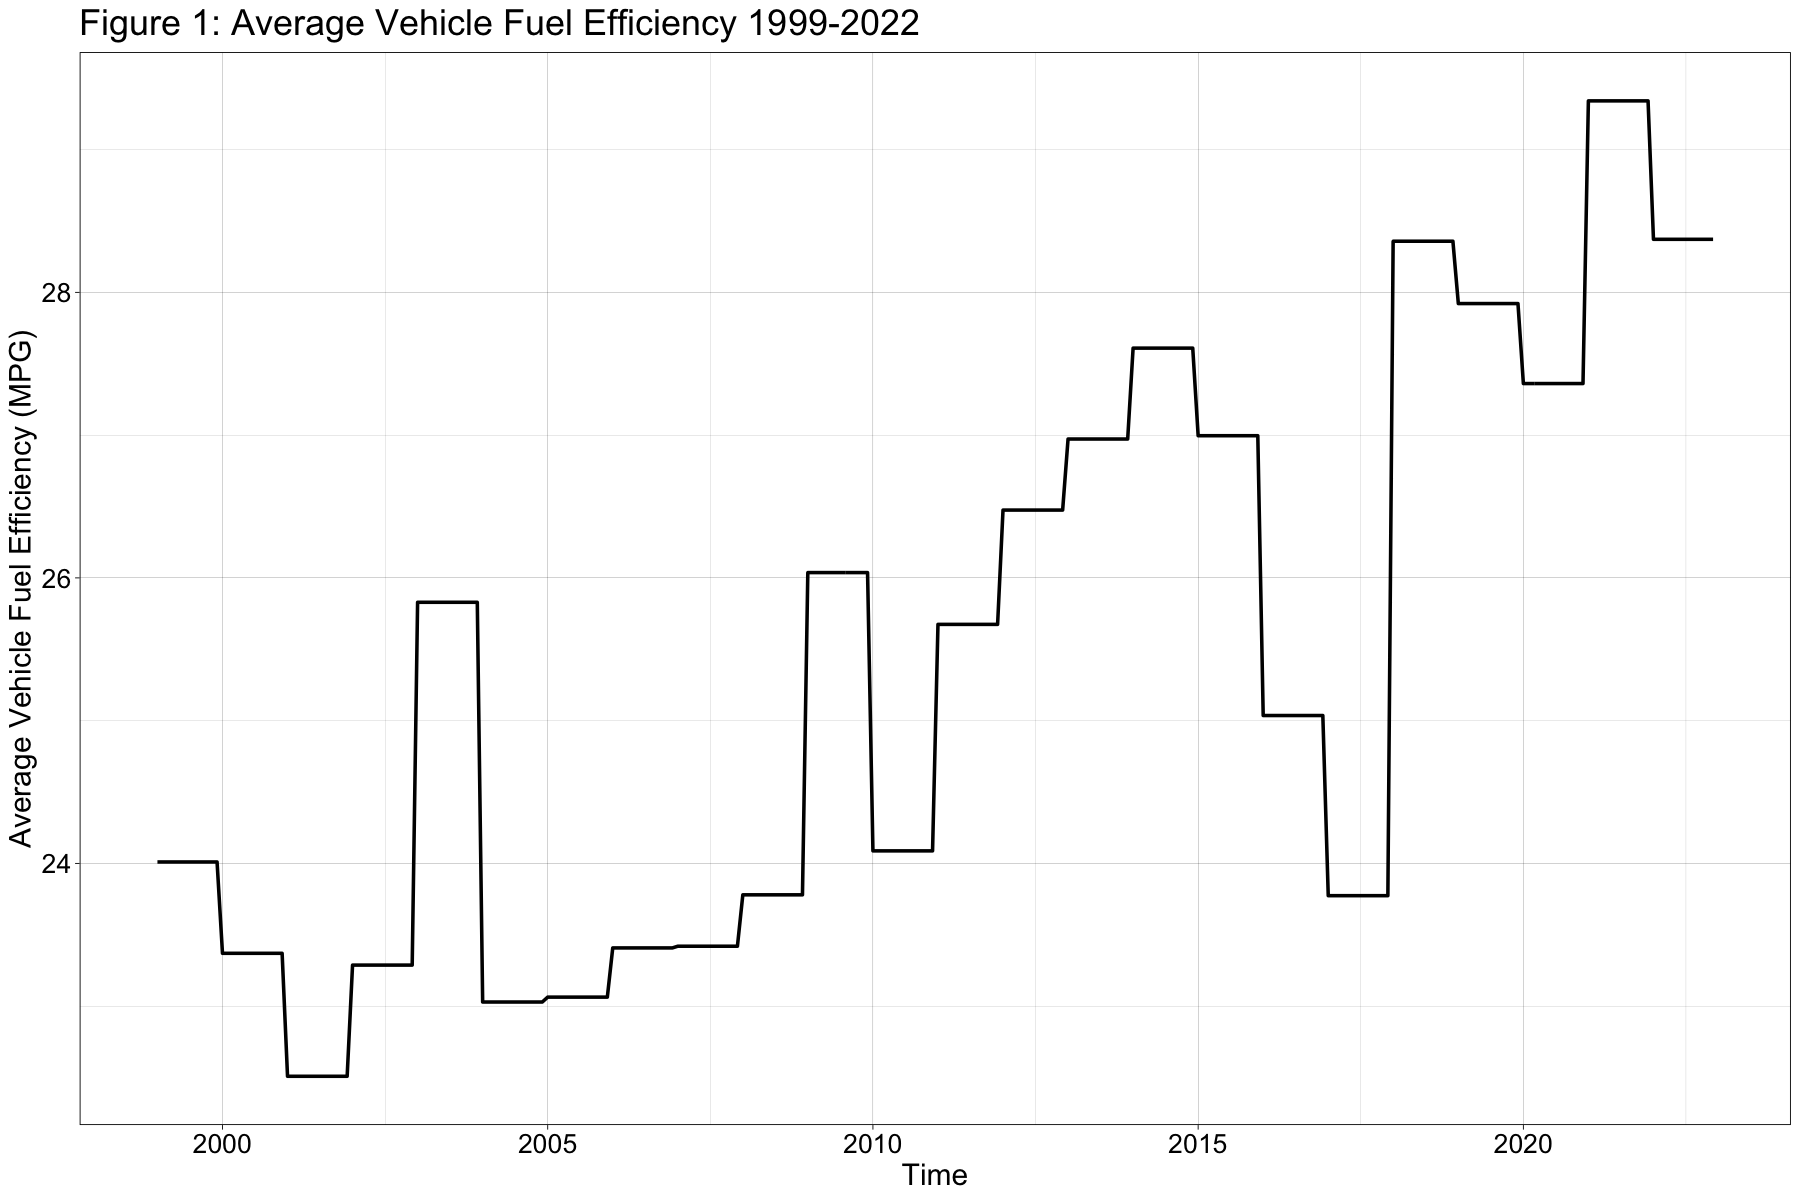

In [1273]:
ggplot(gas, aes(time,avg.mpg)) + geom_line(lwd=1) + 
    labs(x = 'Time', y = 'Average Vehicle Fuel Efficiency (MPG)',
        title = 'Figure 1: Average Vehicle Fuel Efficiency 1999-2022') + theme

## Indiana Gasoline Tax

### Forecast

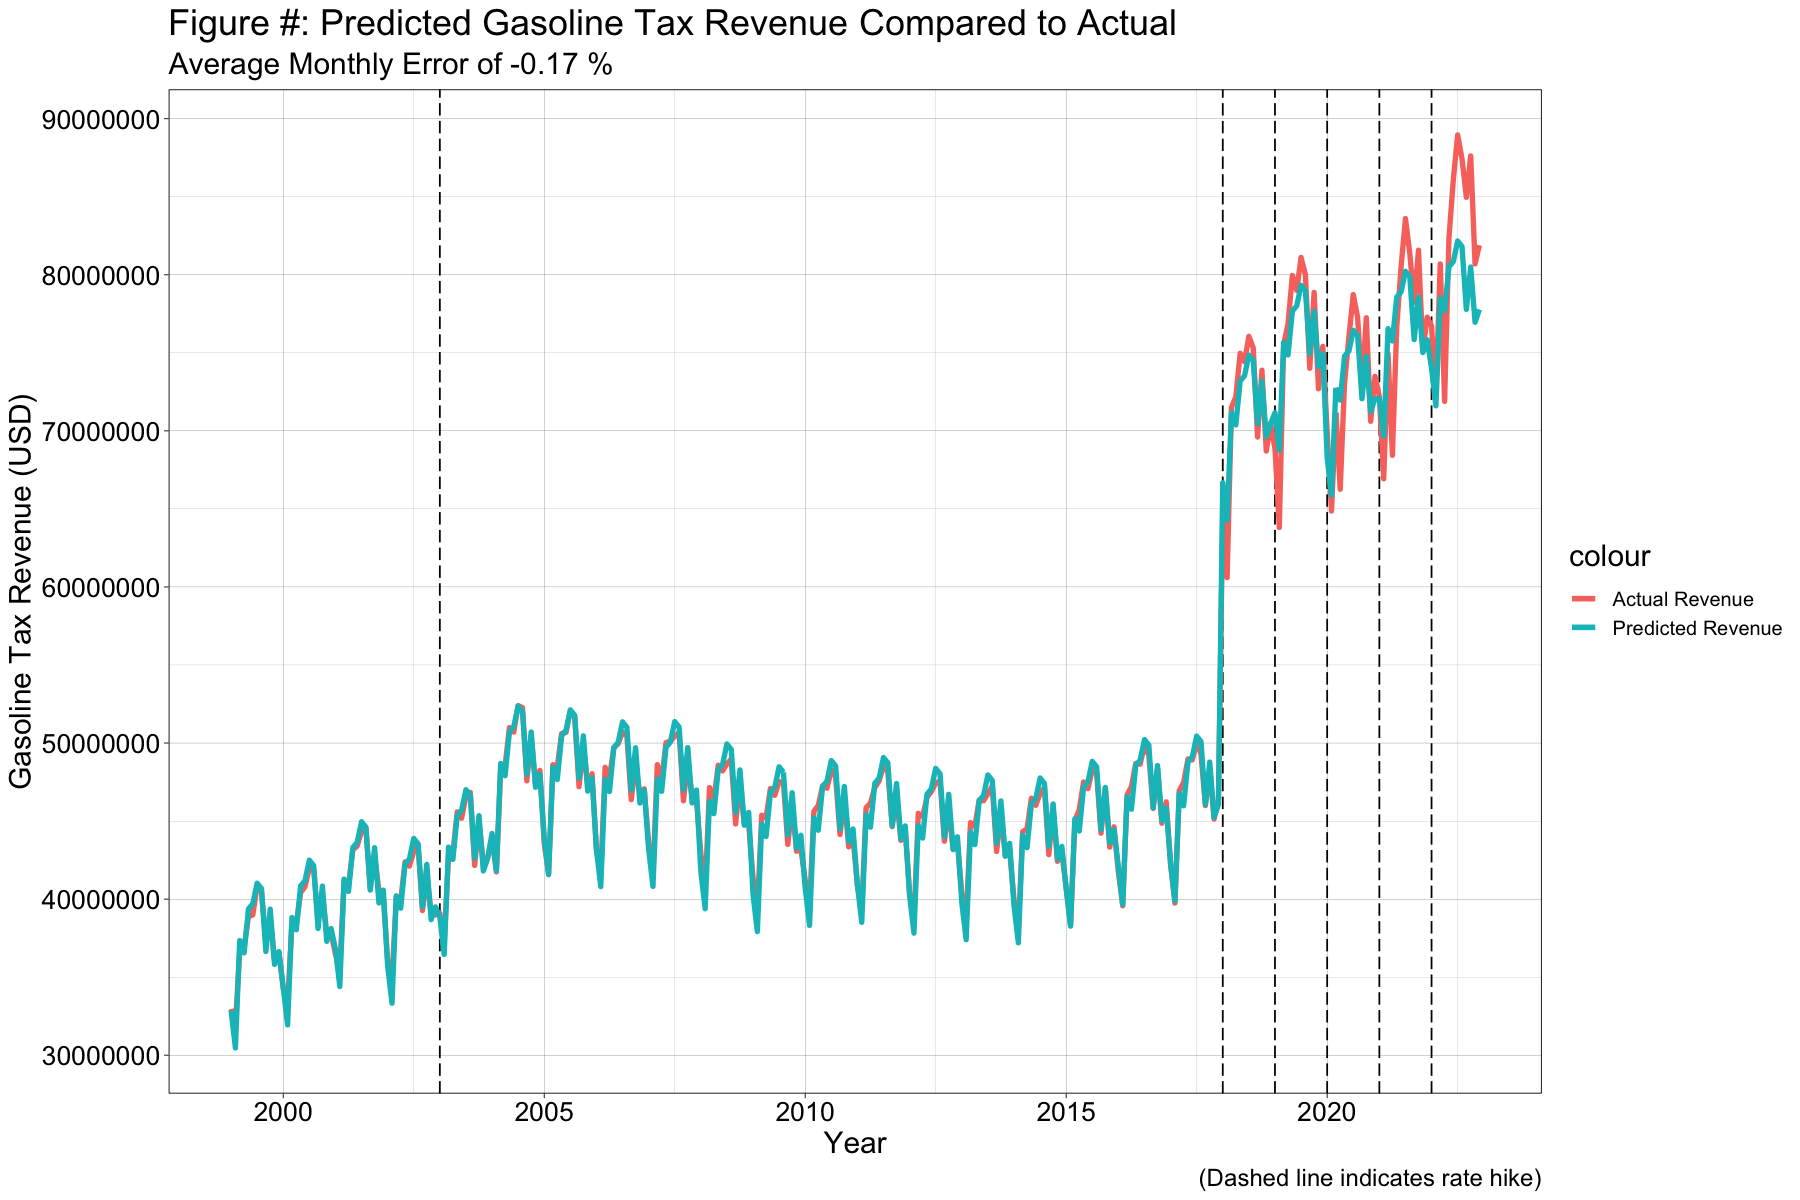

In [1274]:
# Comparison to Actual
ggplot(gas) + theme +
    geom_vline(xintercept=c(2003,2018,2019,2020,2021,2022),linetype=5) + 
    geom_line(aes(time,gas.rev.mnth,color='Actual Revenue'),lwd=1.5) + 
    geom_line(aes(time,rev.hat,color='Predicted Revenue'),lwd=1.5) +
    labs(x = 'Year', y = 'Gasoline Tax Revenue (USD)',
        title = 'Figure #: Predicted Gasoline Tax Revenue Compared to Actual',
        subtitle = paste('Average Monthly Error of',round(mean((gas$rev.hat-gas$gas.rev.mnth)/gas$gas.rev.mnth)*100,2),'%'),
        caption = '(Dashed line indicates rate hike)')

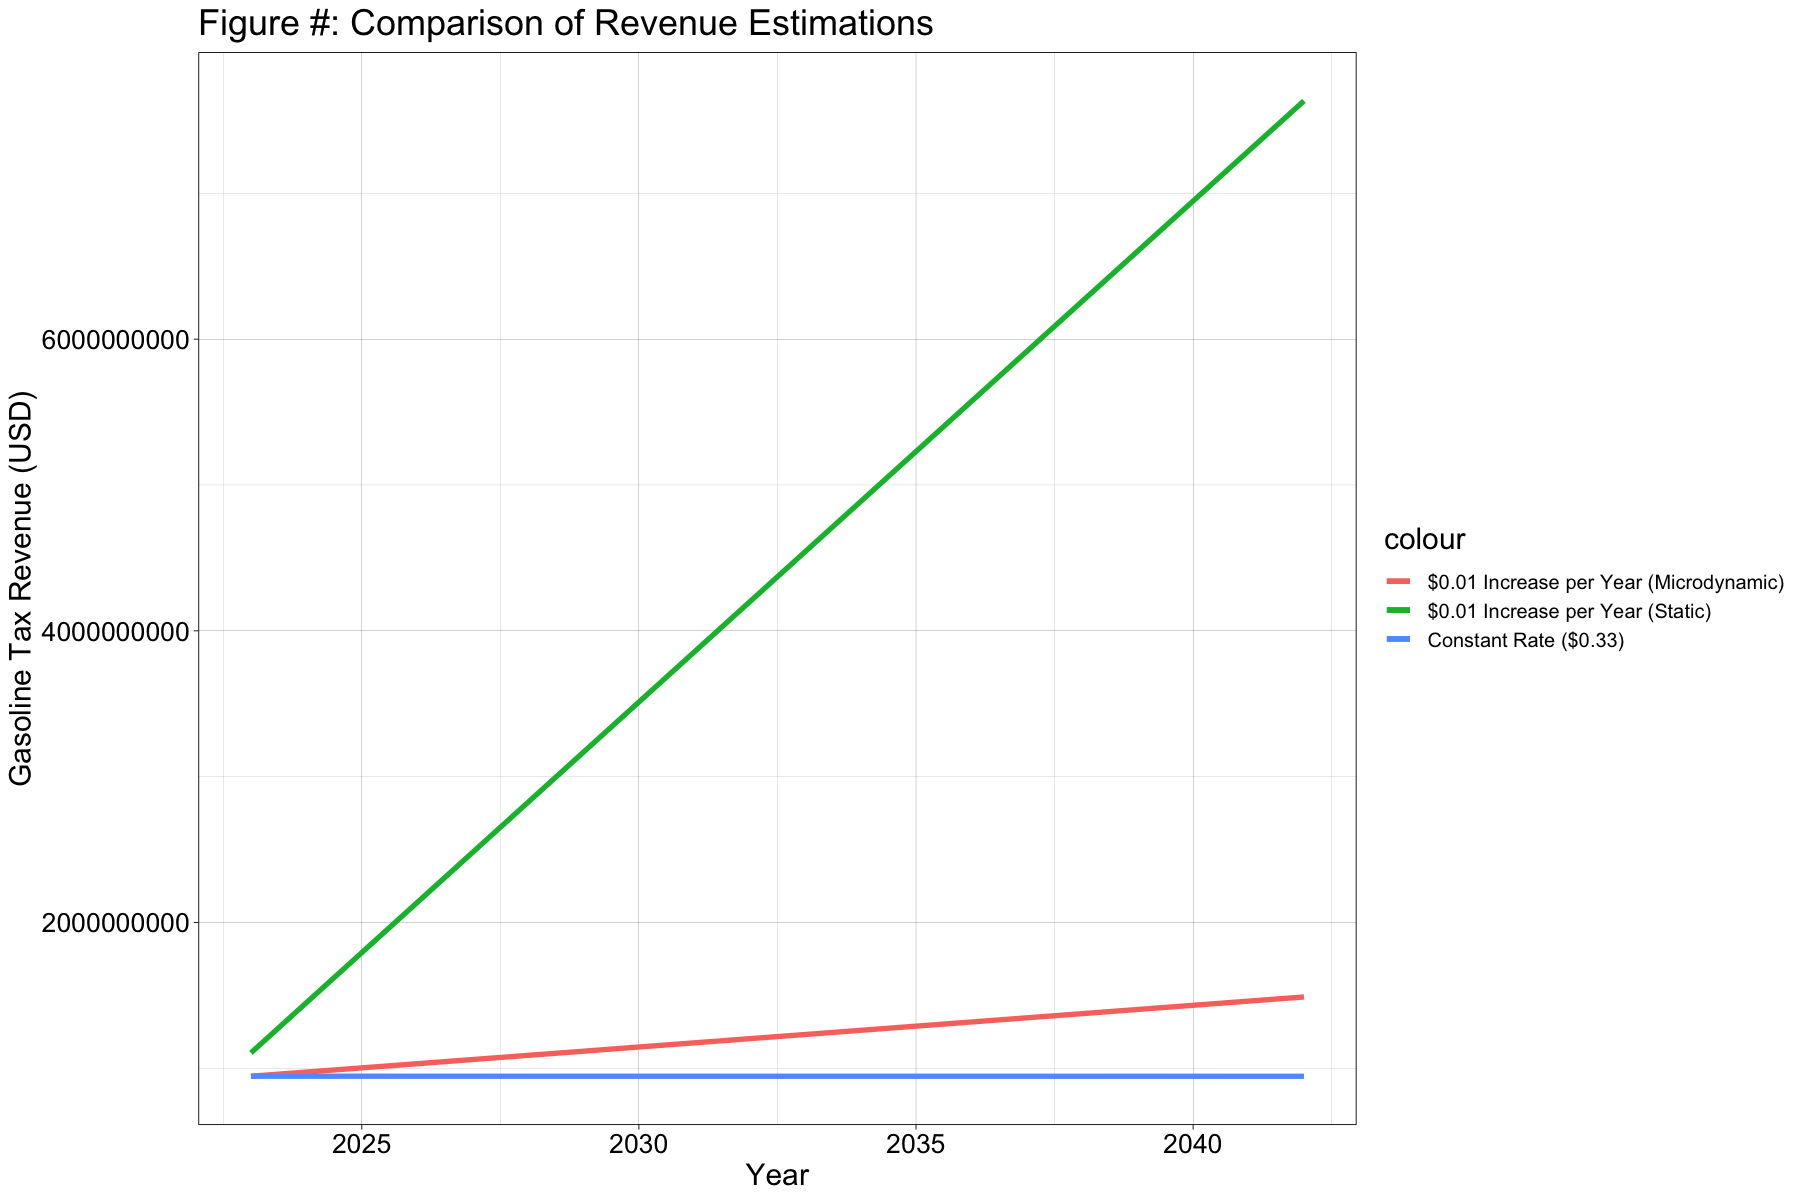

In [1275]:
# Forecast
ggplot(scoreg.fc) + theme +
    geom_line(aes(year,rev.static, color='$0.01 Increase per Year (Static)'),lwd=1.5) + 
    geom_line(aes(year,rev.micro, color='$0.01 Increase per Year (Microdynamic)'),lwd=1.5) +
    geom_line(data=constg.fc,aes(year,rev,color='Constant Rate ($0.33)'),lwd=1.5) +
    labs(x = 'Year', y = 'Gasoline Tax Revenue (USD)',
        title = 'Figure #: Comparison of Revenue Estimations')

### Adequacy Assessment

In [1276]:
# 2022 USD
data.frame(Buoyancy = buoy.gas$coefficients[[2]],
    Elasticity = elas.gas$coefficients[[2]],
    `Revenue Stability` = stabg[1,1]*100,
    row.names = 'Gasoline Tax')

,Buoyancy,Elasticity,Revenue.Stability
,<dbl>,<dbl>,<dbl>
Gasoline Tax,0.4631147,-0.07843454,10.74462


### MPG and Income Correlation

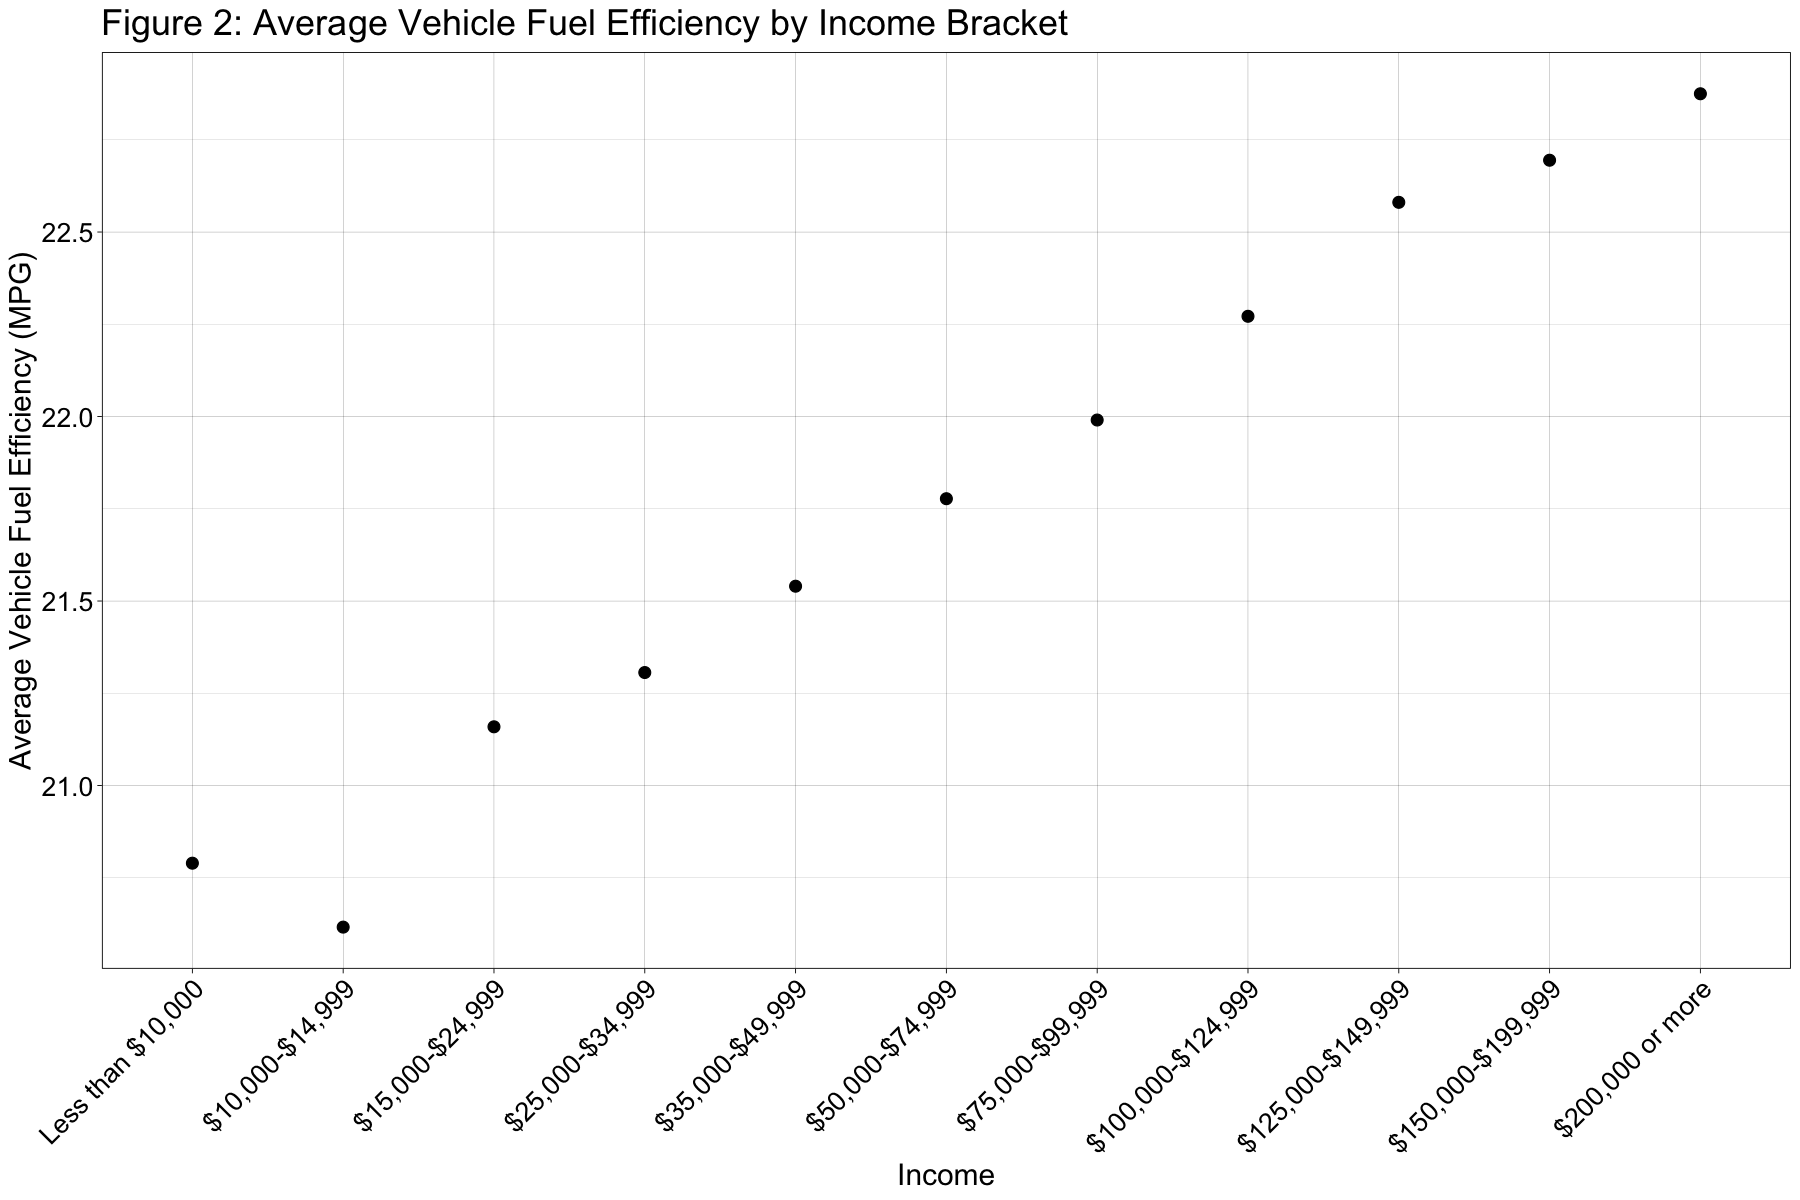

In [1277]:
ggplot(incmpg, aes(fct_inorder(Bracket),mpg)) + geom_point(size=3) + 
    labs(x = 'Income', y = 'Average Vehicle Fuel Efficiency (MPG)',
        title = 'Figure 2: Average Vehicle Fuel Efficiency by Income Bracket') + theme + 
        theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

### Income and VMT Correlation

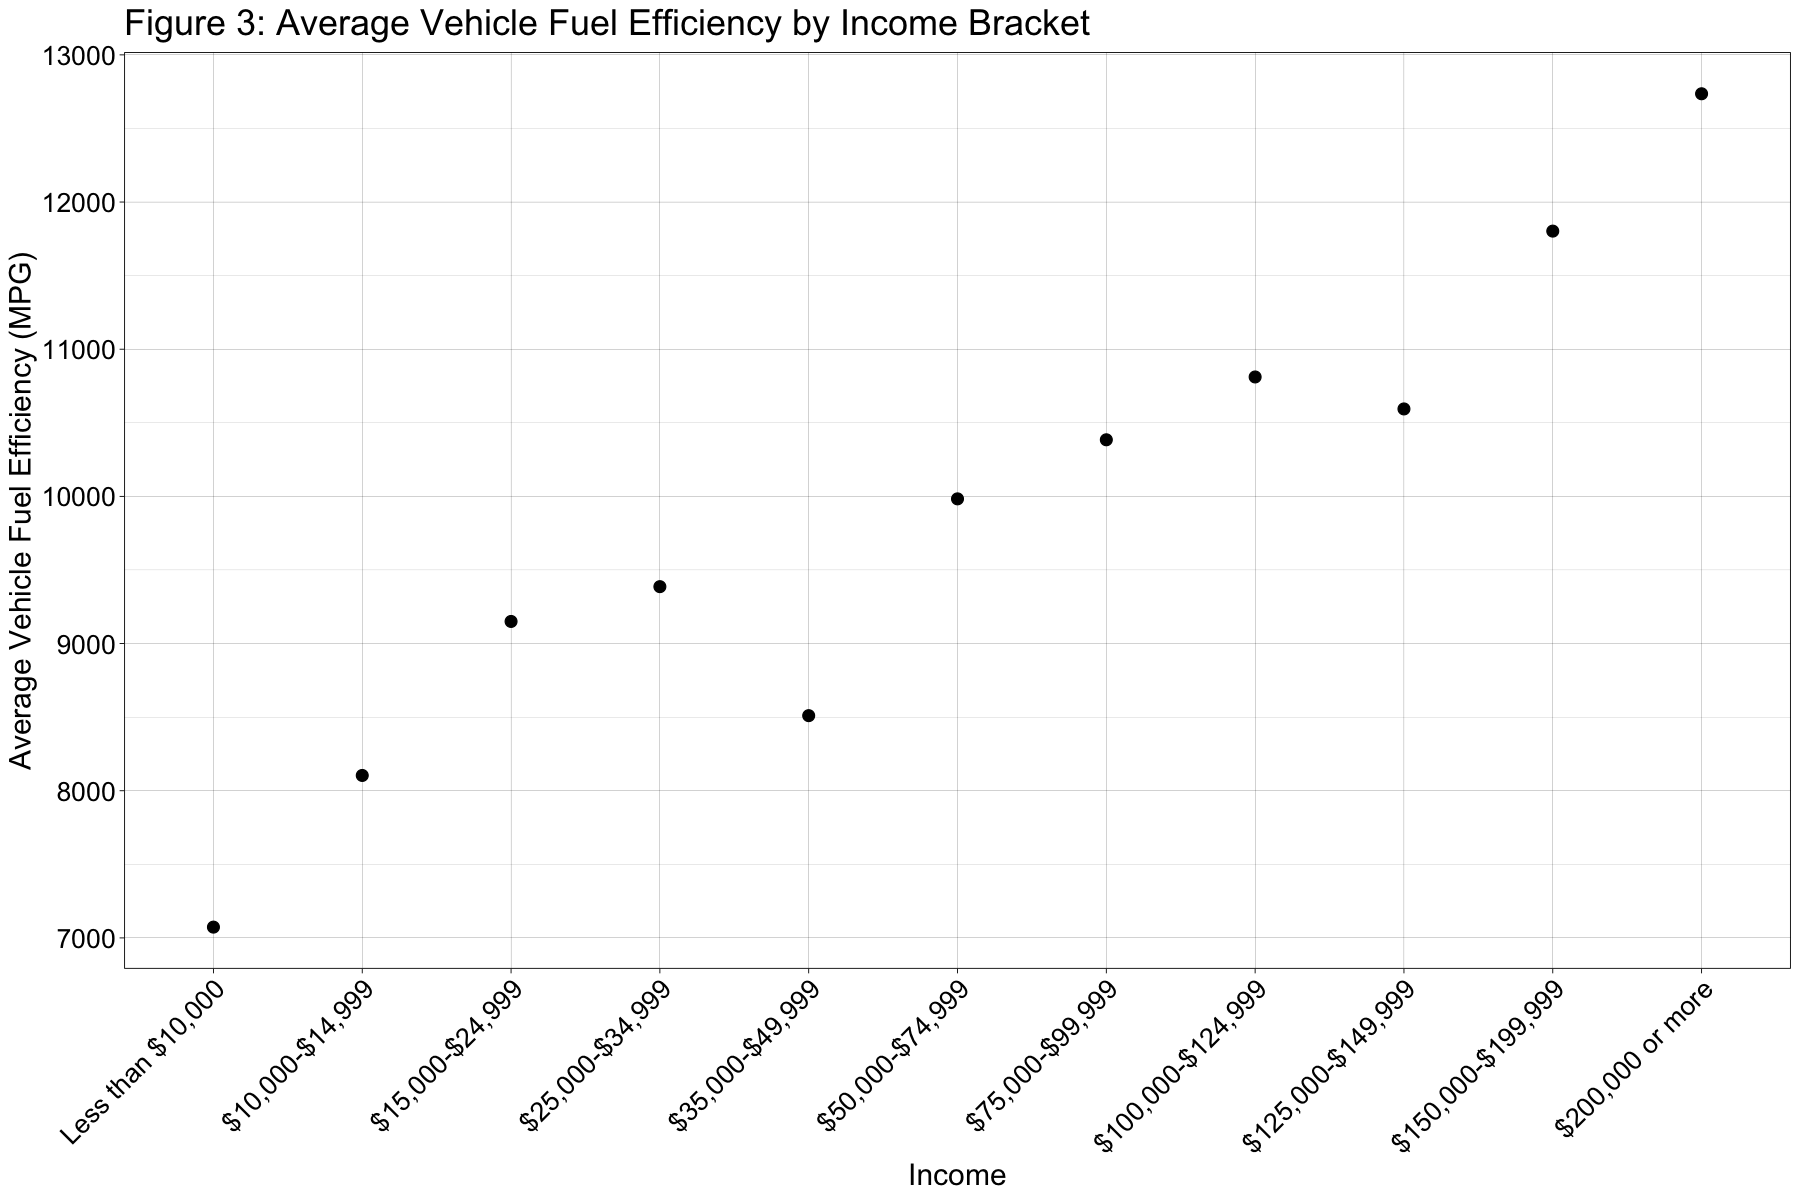

In [1278]:
ggplot() + geom_point(data = incmile.mean, aes(fct_inorder(Bracket),BESTMILE),size=3) +
    labs(x = 'Income', y = 'Average Vehicle Fuel Efficiency (MPG)',
        title = 'Figure 3: Average Vehicle Fuel Efficiency by Income Bracket') + theme + 
        theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

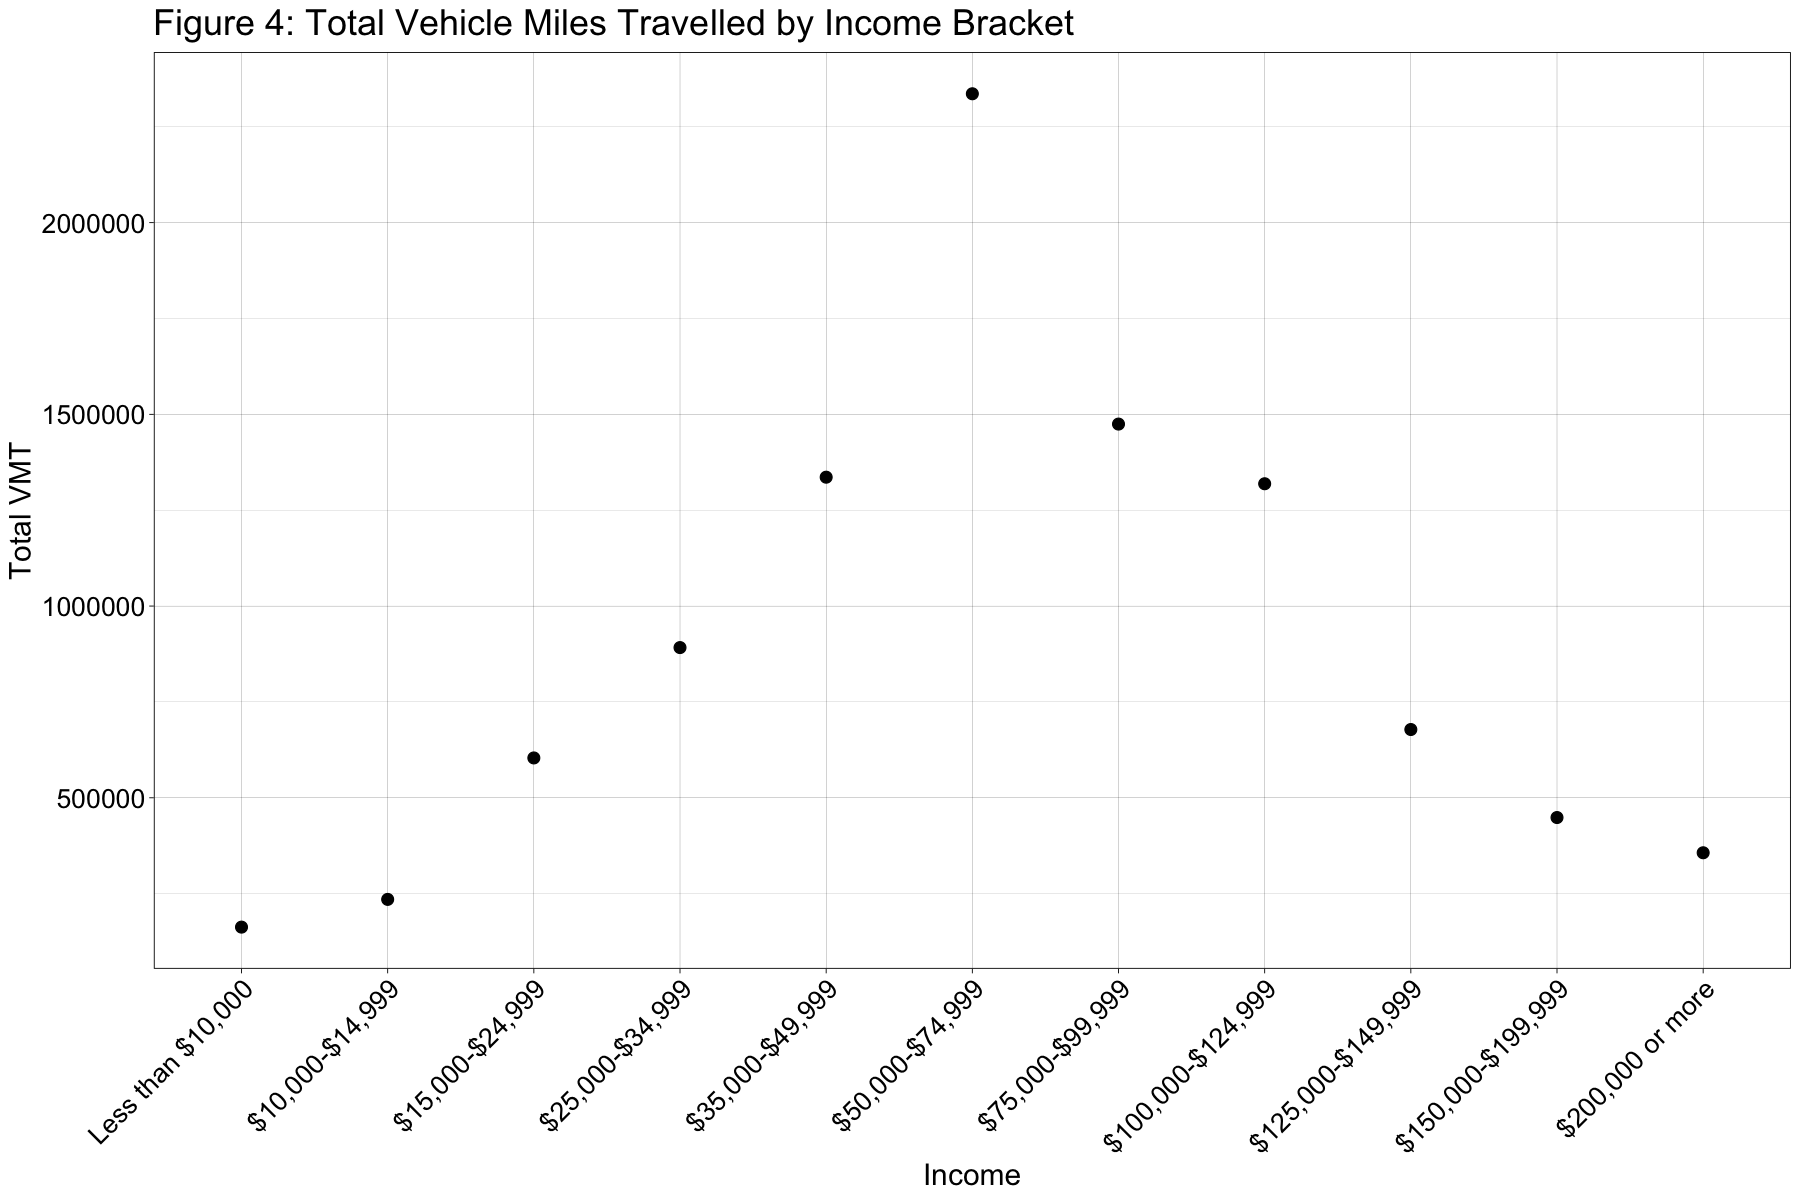

In [1279]:
ggplot() + geom_point(data = incmile.sum, aes(fct_inorder(Bracket),BESTMILE),size=3) +
    labs(x = 'Income', y = 'Total VMT',
        title = 'Figure 4: Total Vehicle Miles Travelled by Income Bracket') + theme + 
        theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

### Suits Index

#### Gas (Historical)

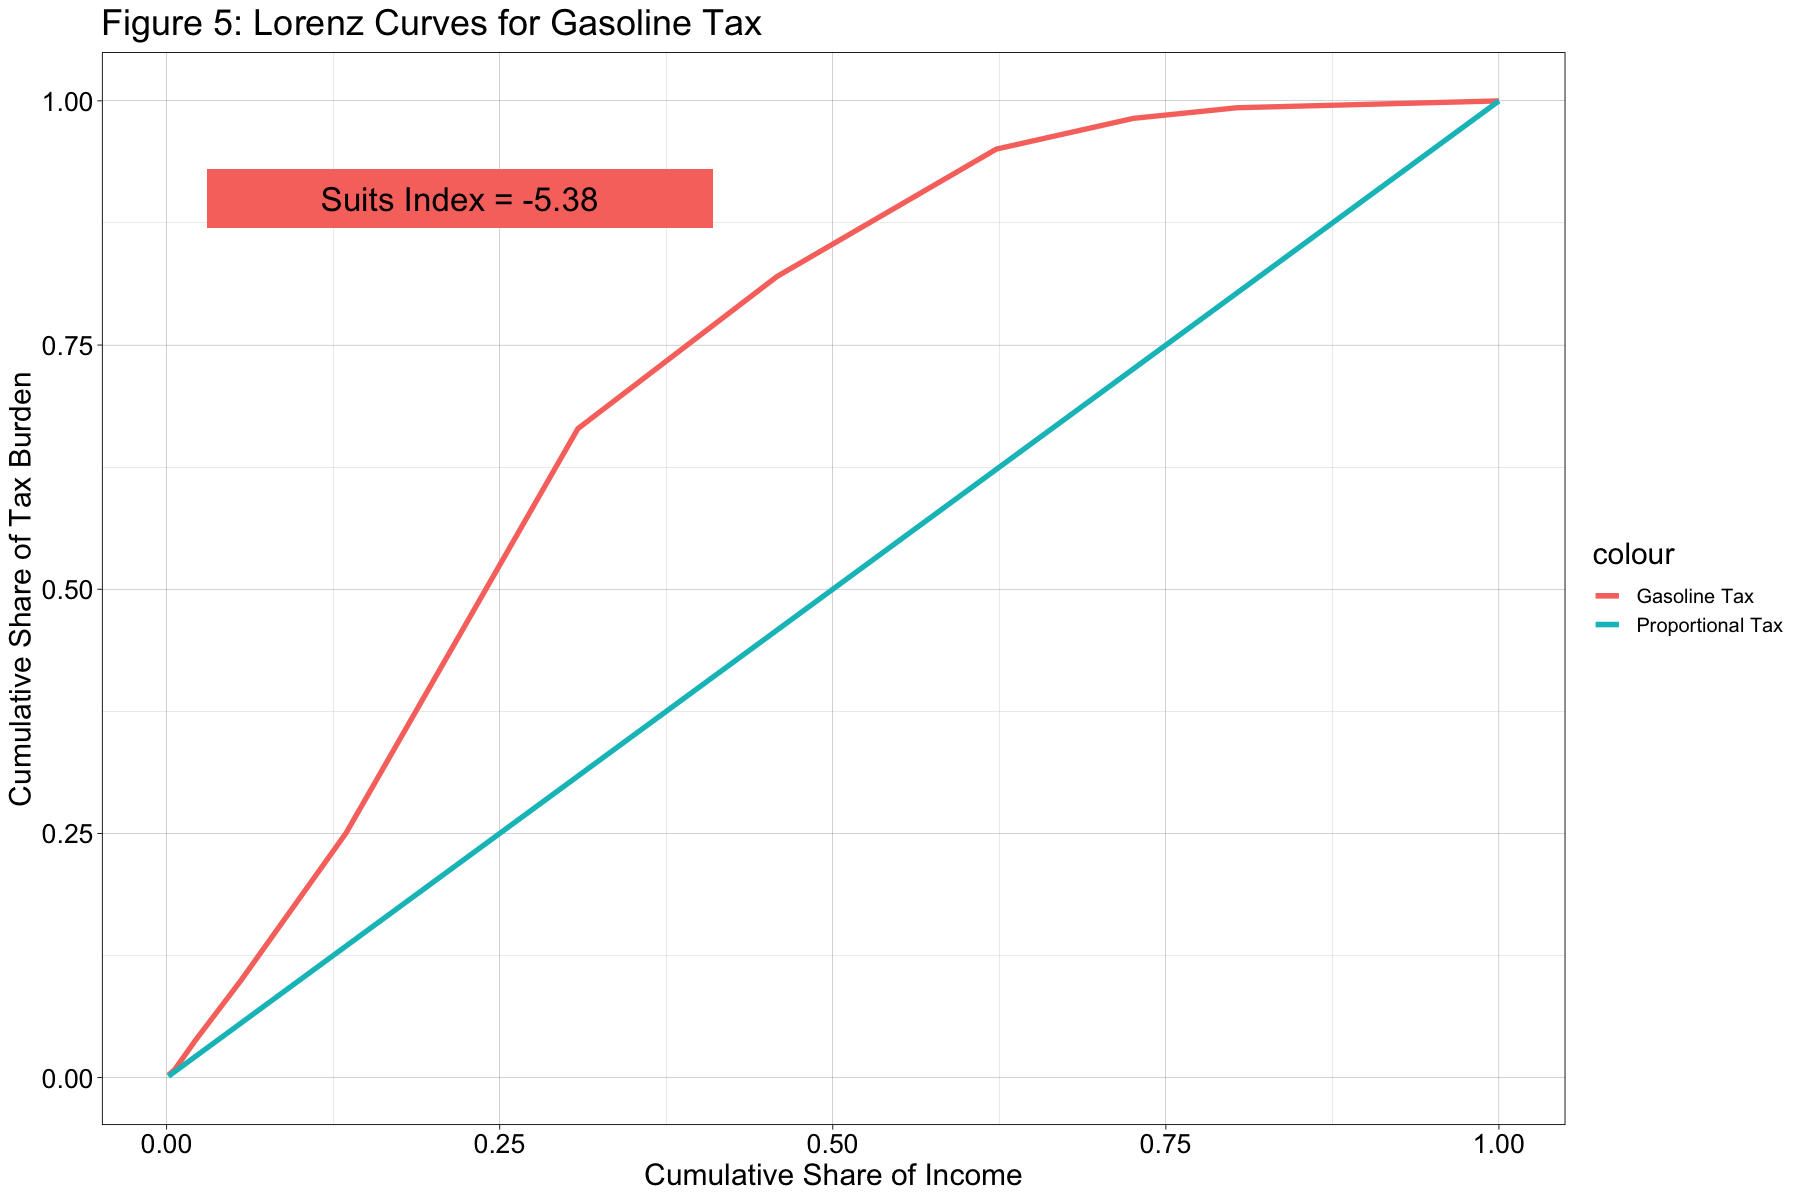

In [1280]:
# x = cumulative income share, y = cumulative tax burden
ggplot(g.suits) + 
    geom_line(aes(cuminc,cumbur, color='Gasoline Tax'),lwd=1.5) + 
    geom_line(aes(cuminc,cuminc, color='Proportional Tax'),lwd=1.5) + theme + 
    labs(x = 'Cumulative Share of Income', y = 'Cumulative Share of Tax Burden',
        title = 'Figure 5: Lorenz Curves for Gasoline Tax') + 
    geom_rect(aes(xmin=.03,ymin=.87,xmax=.41,ymax=.93, fill='white'),show.legend=FALSE) + 
    annotate(geom='text', y=.9, x=.22,label=paste('Suits Index =',round((sum(g.suits$k)-sum(g.suits$l))/sum(g.suits$k),2)),
        size=7)

### Effect of EVs on Fuel Consumption

In [1281]:
paste('A 1% increase in the number of EVs in the state will reduce monthly gas tax revenue by $',-round(rel.m$coefficients[[4]]/100,2),'on average, c.p.')



[1] "A 1% increase in the number of EVs in the state will reduce monthly gas tax revenue by $ 23915.65 on average, c.p."

## VMT Tax

### Forecast

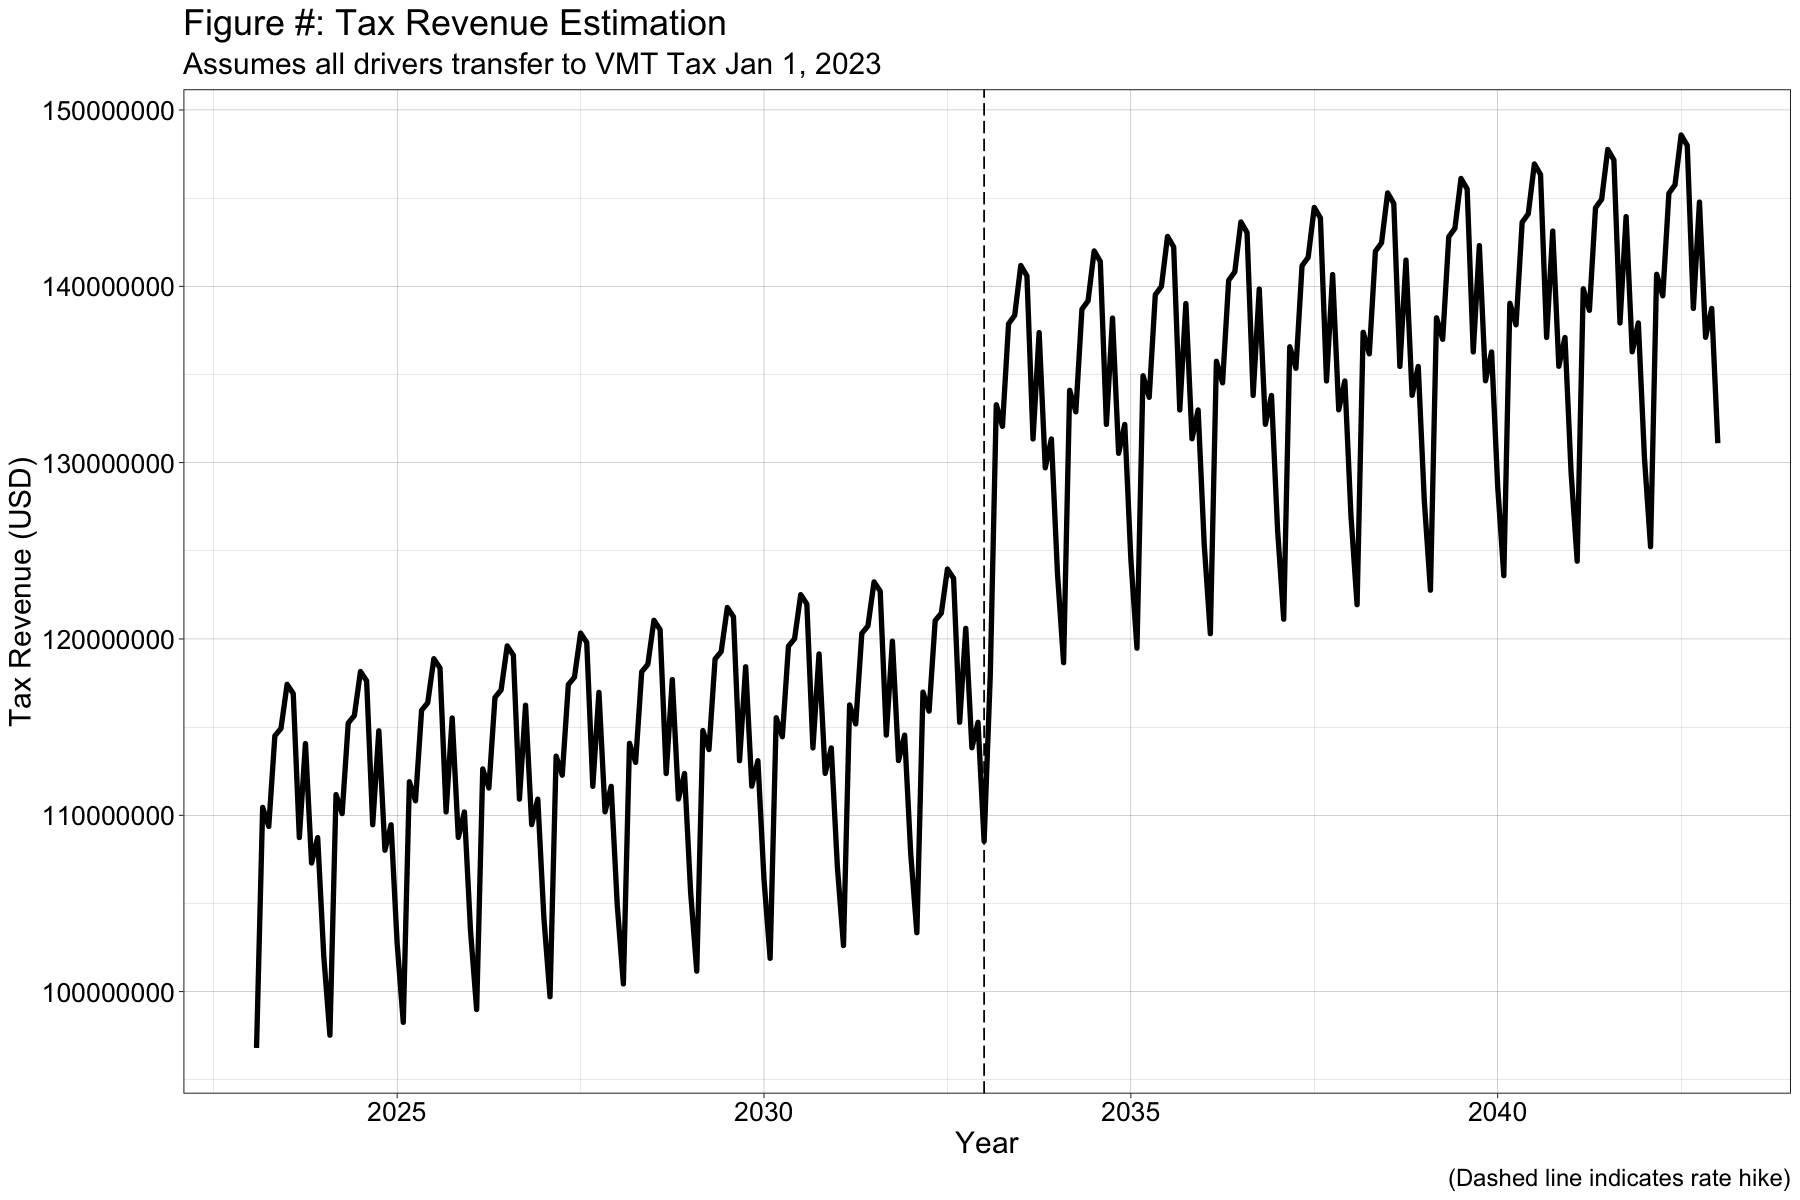

In [1291]:
ggplot(vmt.fc1) + theme + 
    geom_vline(xintercept = 2033,linetype=5) + 
    geom_line(aes(time,rev),lwd=1.5) +
    labs(x = 'Year', y = 'Tax Revenue (USD)',
        title = 'Figure #: Tax Revenue Estimation',
        subtitle = 'Assumes all drivers transfer to VMT Tax Jan 1, 2023',
        caption = '(Dashed line indicates rate hike)')

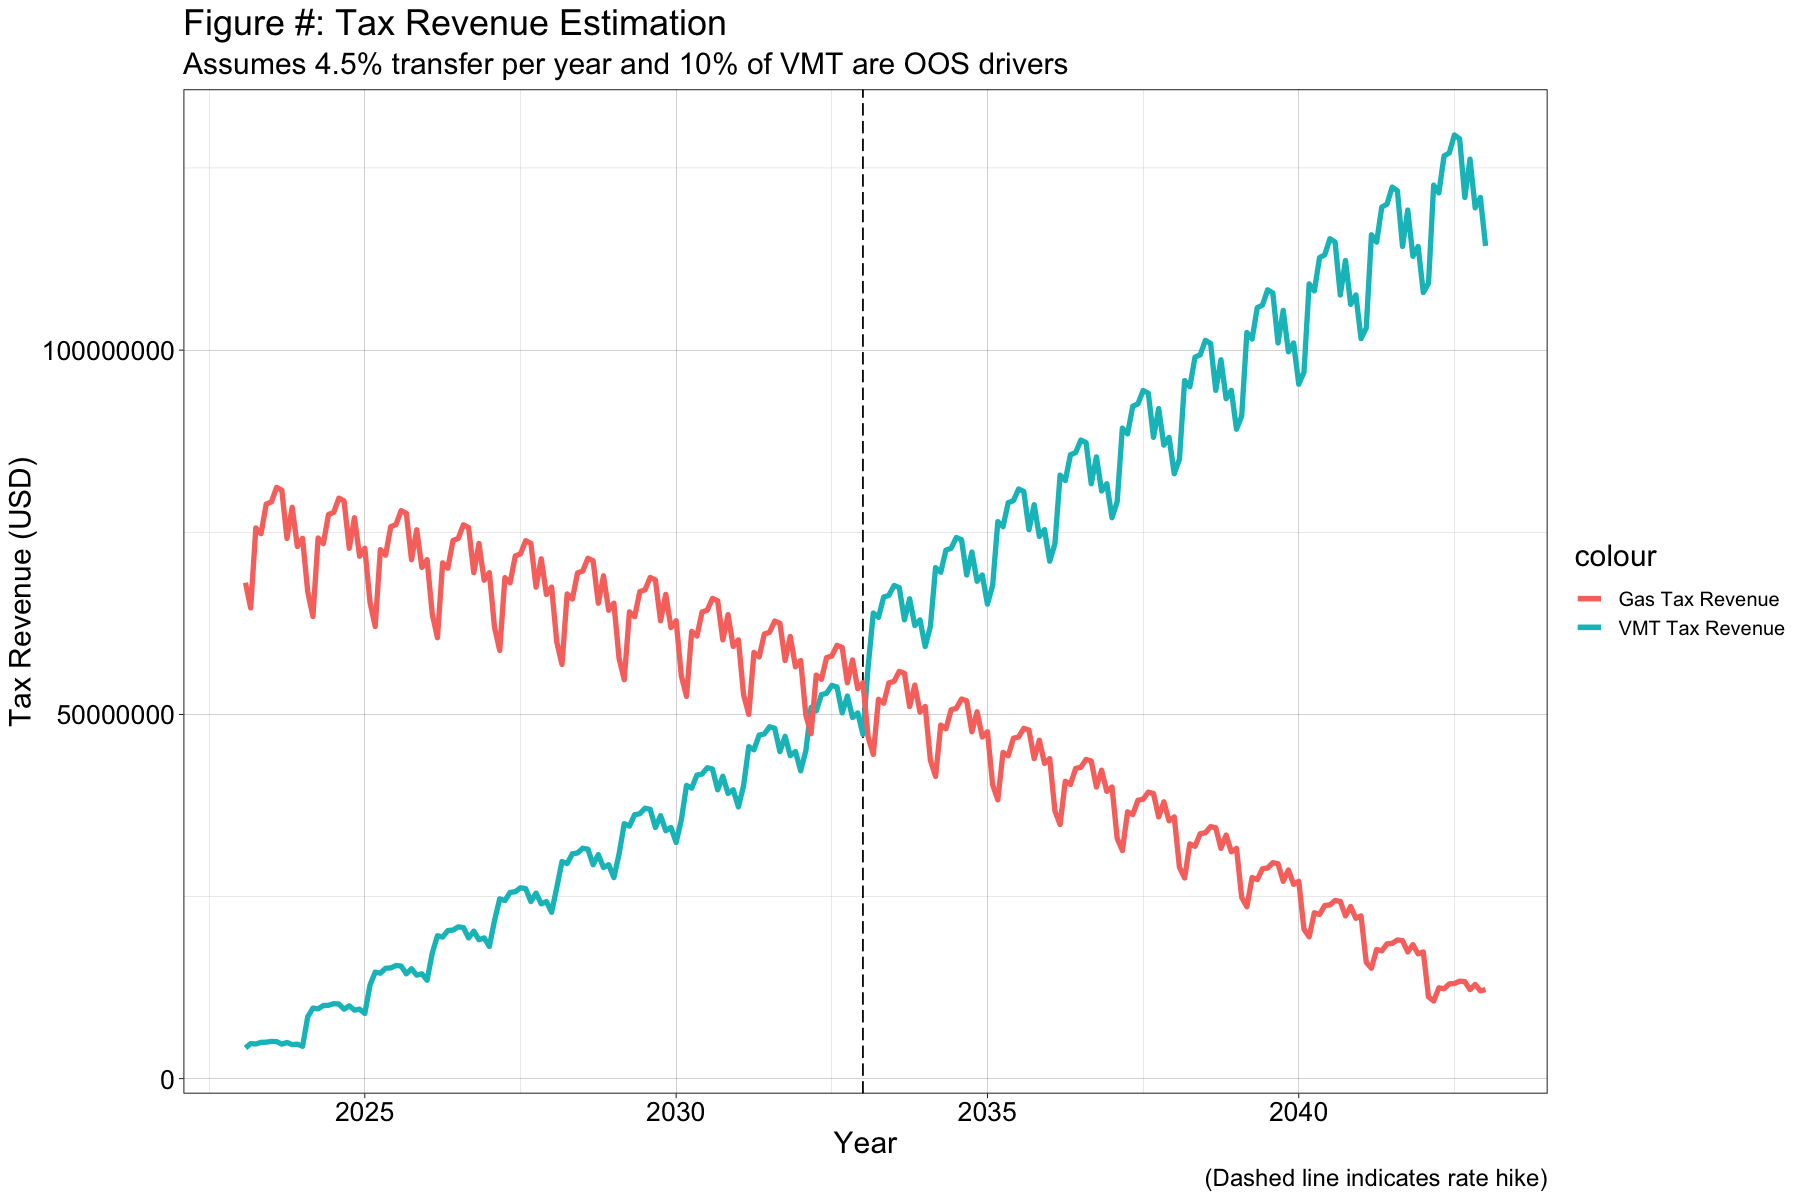

In [1293]:
ggplot(vmt.fc2) + theme + 
    geom_vline(xintercept = 2033,linetype=5) + 
    geom_line(aes(time,adj.rev,color='VMT Tax Revenue'),lwd=1.5) + 
    geom_line(aes(time,adj.gasrev,color='Gas Tax Revenue'),lwd=1.5) + 
    labs(x = 'Year', y = 'Tax Revenue (USD)',
        title = 'Figure #: Tax Revenue Estimation',
        subtitle = 'Assumes 4.5% transfer per year and 10% of VMT are OOS drivers',
        caption = '(Dashed line indicates rate hike)')

### Forecast Comparison

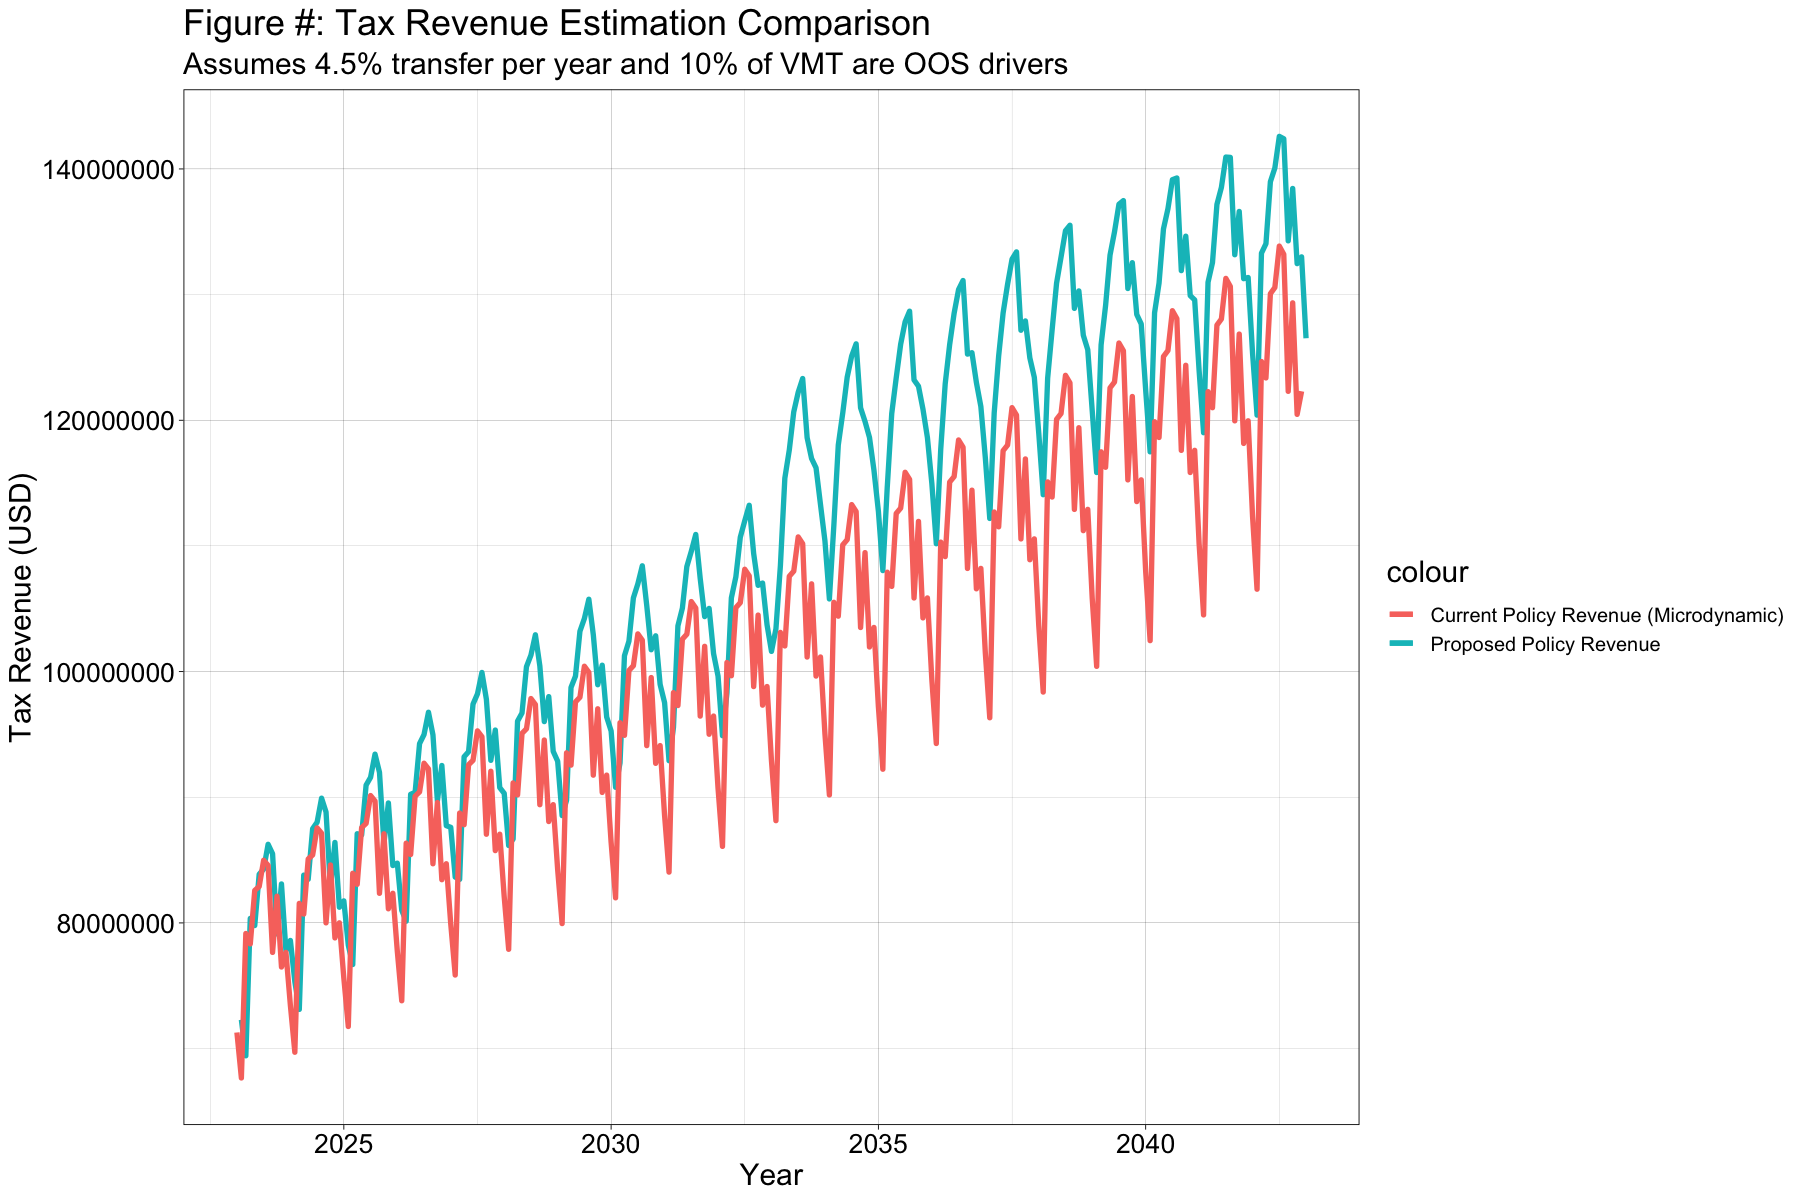

In [1284]:
ggplot(vmt.fc2) + theme + 
    geom_line(aes(time,adj.rev+adj.gasrev,color='Proposed Policy Revenue'),lwd=1.5) + 
    geom_line(data=microg.fc,aes(time,rev.micro,color='Current Policy Revenue (Microdynamic)'),lwd=1.5) +
    labs(x = 'Year', y = 'Tax Revenue (USD)',
        title = 'Figure #: Tax Revenue Estimation Comparison',
        subtitle = 'Assumes 4.5% transfer per year and 10% of VMT are OOS drivers')

### Adequacy

In [1288]:
data.frame(Buoyancy = c(buoy.vmt$coefficients[[2]],buoy.gas$coefficients[[2]]),
    Elasticity = c(elas.vmt$coefficients[[2]],elas.gas$coefficients[[2]]),
    `Revenue Stability` = c(stabvmt[1,1]*100,stabg[1,1]*100),
    row.names = c('VMT Tax','Gasoline Tax'))

,Buoyancy,Elasticity,Revenue.Stability
,<dbl>,<dbl>,<dbl>
VMT Tax,0.4358083,0.17473699,3.053004
Gasoline Tax,0.4631147,-0.07843454,10.744618


### Suits Index

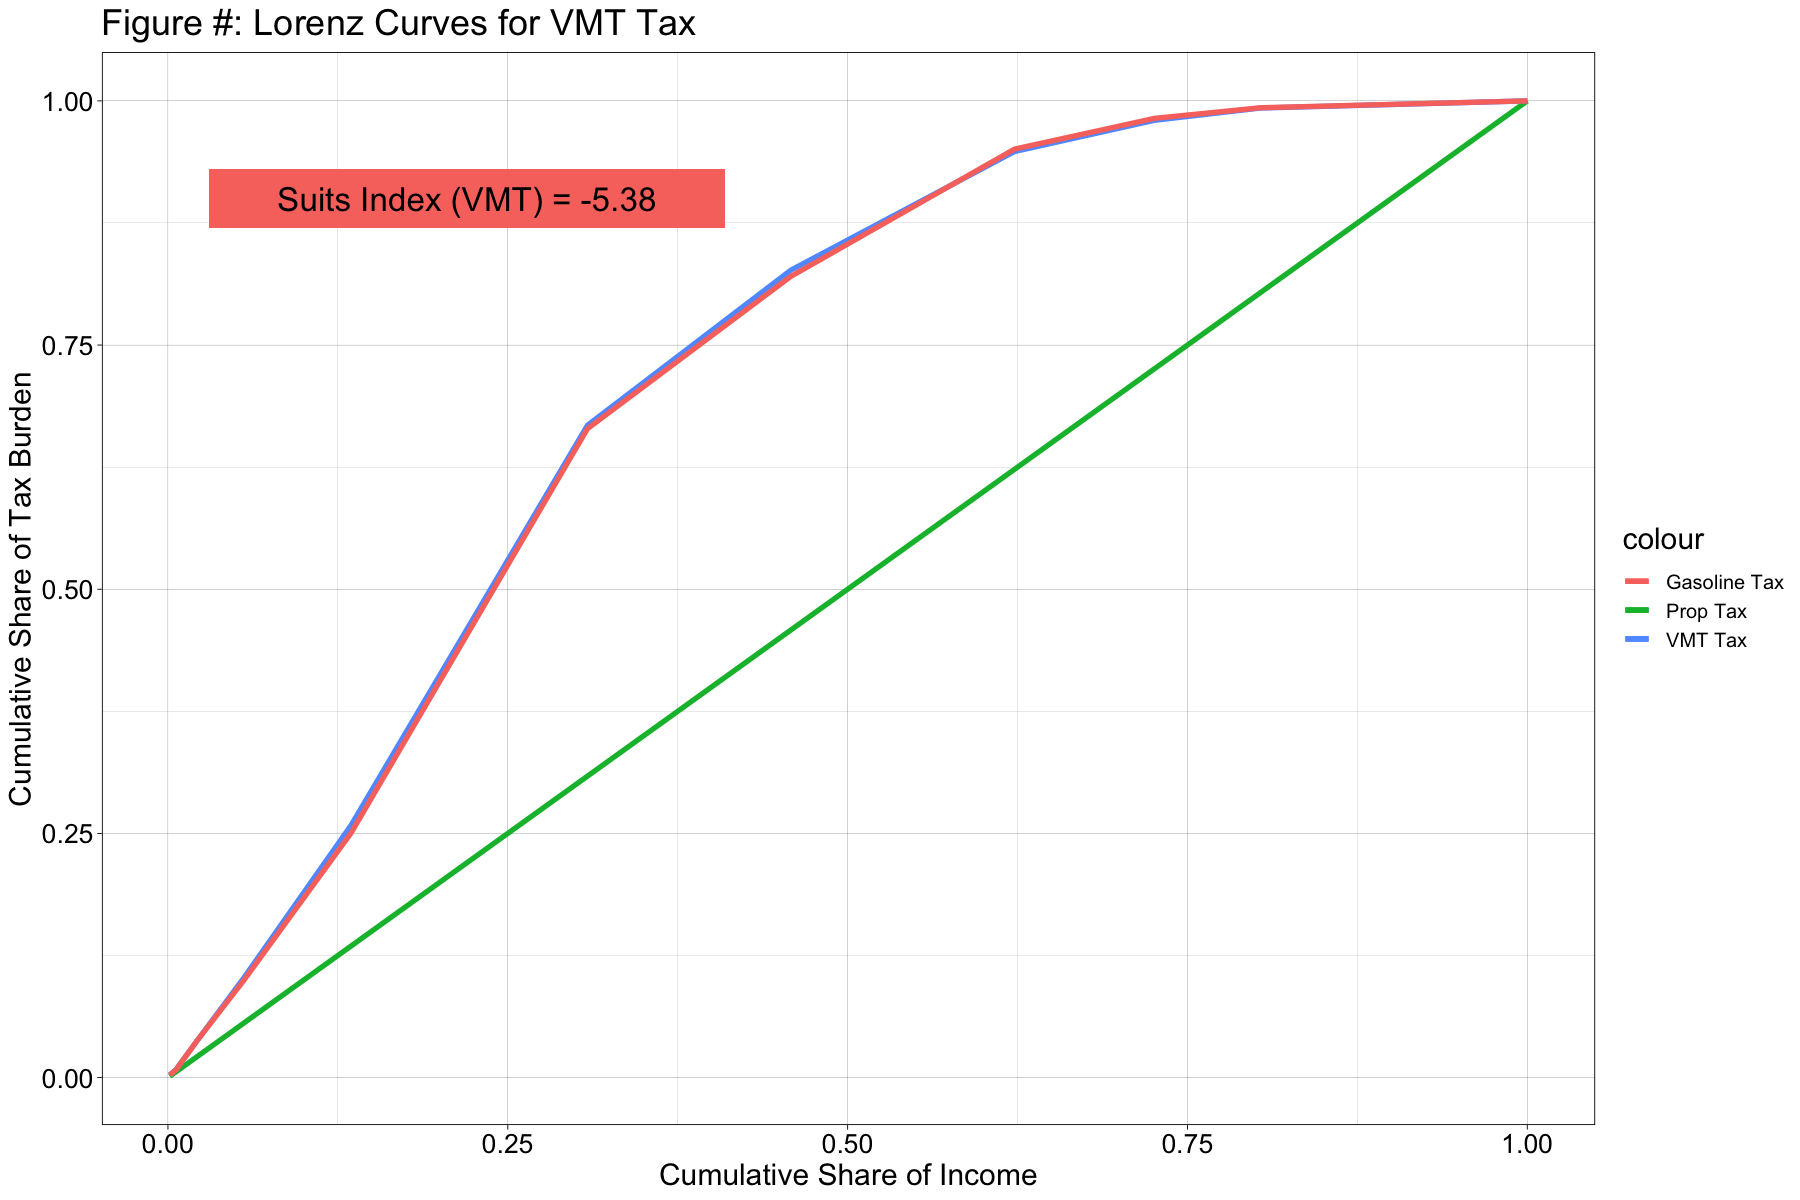

In [1286]:
# x = cumulative income share, y = cumulative tax burden
ggplot(v.suits) + theme + 
    geom_line(aes(cuminc,cuminc, color='Prop Tax'),lwd=1.5) +
    geom_line(aes(cuminc,cumbur, color='VMT Tax'),lwd=1.5) + 
    geom_line(data = g.suits, aes(cuminc,cumbur, color='Gasoline Tax'),lwd=1.5) + 
    labs(x = 'Cumulative Share of Income', y = 'Cumulative Share of Tax Burden',
        title = 'Figure #: Lorenz Curves for VMT Tax') + 
    geom_rect(aes(xmin=.03,ymin=.87,xmax=.41,ymax=.93, fill='white'),show.legend=FALSE) + 
    annotate(geom='text', y=.9, x=.22,label=paste('Suits Index (VMT) =',round((sum(v.suits$k)-sum(v.suits$l))/sum(v.suits$k),2)),
        size=7)

### Remittances

In [1287]:
data.frame(`Current Policy` = c(70000000,(gas.fc.ann$gas.rev[1]-70000000)*.75,(gas.fc.ann$gas.rev[1]-70000000)*.25),
    `Option 1` = c(70000000,(vmt.fc1.year$rev[1]-70000000)*.75,(vmt.fc1.year$rev[1]-70000000)*.25),
    `Option 2` = c(vmt.fc1.year$rev[1]*.10,vmt.fc1.year$rev[1]*.70,vmt.fc1.year$rev[1]*.20),
    row.names = c('State Road Construction and Improvement Fund','Motor Vehicle Highway Account','Highway Road and Street Account'))

,Current.Policy,Option.1,Option.2
,<dbl>,<dbl>,<dbl>
State Road Construction and Improvement Fund,70000000,70000000,132121536
Motor Vehicle Highway Account,670044607,938411522,924850754
Highway Road and Street Account,223348202,312803841,264243073
